# 03: Model Training

**ProToPhen: Protein-to-Phenotype Foundation Model**

This notebook demonstrates how to train the ProToPhen model for predicting cellular
phenotypes from protein embeddings. We cover the complete training workflow including:

- Dataset preparation and data loading
- Model architecture configuration
- Training loop with callbacks
- Evaluation and visualisation
- Model checkpointing and transfer learning

**Contents**
1. [Introduction](#1-introduction)
2. [Setup](#2-setup)
3. [Preparing Data](#3-preparing-data)
4. [Data Splitting](#4-data-splitting)
5. [Model Architecture](#5-model-architecture)
6. [Training Configuration](#6-training-configuration)
7. [Callbacks](#7-callbacks)
8. [Training Loop](#8-training-loop)
9. [Evaluation](#9-evaluation)
10. [Saving and Loading Models](#10-saving-and-loading-models)
11. [Hyperparameter Tuning Tips](#11-hyperparameter-tuning-tips)
12. [Summary & Next Steps](#12-summary--next-steps)


## Prerequisites

Before running this notebook, ensure you have:
1. Completed **Notebook 1** (protein embeddings extracted)
2. Completed **Notebook 2** (phenotype data processed)
3. Installed all required dependencies (`pip install -e .`)

## 1. Introduction

### 1.1 ProToPhen Model Architecture (NOTE: REPLACE WITH ACTUAL FIGURE)

ProToPhen uses an encoder-decoder architecture to map protein embeddings to cellular phenotypes:

```
Protein Embedding (ESM-2 + Physicochemical)
         │
         ▼
┌─────────────────────┐
│   Protein Encoder   │  MLP with residual connections
│   (1719 → 256 dim)  │  LayerNorm, GELU, Dropout
└─────────────────────┘
         │
         ▼
   Latent Space (256)
         │
    ┌────┴────┬────────────┐
    ▼         ▼            ▼
┌────────┐ ┌────────┐ ┌──────────┐
│Cell    │ │Viabil- │ │Transcrip-│
│Painting│ │ity     │ │tomics    │
│(~1500) │ │(1)     │ │(978)     │
└────────┘ └────────┘ └──────────┘
```

**Key Components:**
- **Encoder**: Transforms high-dimensional protein embeddings into a compact latent representation
- **Decoders**: Task-specific heads for predicting different phenotypic readouts
- **Multi-task Learning**: Joint training on multiple phenotype types improves generalisation

### 1.2 Training Workflow Overview

```
1. Data Preparation
   └─ Load embeddings & phenotypes → Create Dataset → Split → DataLoaders

2. Model Setup
   └─ Configure architecture → Initialise model → Move to GPU

3. Training Configuration
   └─ Loss function → Optimiser → LR Scheduler → Callbacks

4. Training Loop
   └─ Forward pass → Compute loss → Backward pass → Update weights

5. Evaluation
   └─ Predict on test set → Compute metrics → Visualise results

6. Save & Deploy
   └─ Checkpoint model → Load for inference
```

## 2. Setup

In [1]:
# Core imports
import os
import sys
import json
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Optional, Tuple

# Scientific computing
import numpy as np
import pandas as pd
from scipy import stats

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm.auto import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

### 2.1 ProToPhen Imports

In [2]:
# Data structures and loading
from protophen.data.dataset import (
    DatasetConfig,
    ProtoPhenSample,
    ProtoPhenDataset,
    ProteinInferenceDataset,
)
from protophen.data.loaders import (
    create_dataloader,
    create_dataloaders,
    create_balanced_sampler,
    split_by_protein,
    split_by_plate,
    protophen_collate_fn,
)

# Model architecture
from protophen.models.protophen import (
    ProToPhenConfig,
    ProToPhenModel,
    create_protophen_model,
    create_lightweight_model,
)
from protophen.models.encoders import ProteinEncoder, ProteinEncoderConfig
from protophen.models.decoders import CellPaintingHead, ViabilityHead, MultiTaskHead
from protophen.models.losses import (
    CombinedLoss,
    CellPaintingLoss,
    MultiTaskLoss,
    create_loss_function,
)

# Training infrastructure
from protophen.training.trainer import (
    Trainer,
    TrainerConfig,
    TrainingState,
    create_trainer,
)
from protophen.training.callbacks import (
    Callback,
    CallbackList,
    CheckpointCallback,
    EarlyStoppingCallback,
    LoggingCallback,
    ProgressCallback,
    TensorBoardCallback,
)
from protophen.training.metrics import (
    MetricCollection,
    MultiTaskMetricCollection,
    MSEMetric,
    MAEMetric,
    R2Metric,
    PearsonCorrelationMetric,
    CosineSimilarityMetric,
    create_default_metrics,
    create_multitask_metrics,
    compute_regression_metrics,
    compute_per_feature_metrics,
    summarise_per_feature_metrics,
)

# Visualisation
from protophen.analysis.visualisation import (
    plot_training_history,
    plot_prediction_scatter,
    plot_residuals,
    plot_embedding_space,
    plot_heatmap,
    save_figure,
)

print("All imports successful.")

All imports successful.


### 2.2 Device Configuration

In [3]:
def setup_device(prefer_gpu: bool = True) -> torch.device:
    """
    Configure compute device with informative output.
    
    Args:
        prefer_gpu: Whether to use GPU if available
        
    Returns:
        torch.device object
    """
    if prefer_gpu and torch.cuda.is_available():
        device = torch.device("cuda")
        
        # Print GPU information
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        
        print(f"   Using GPU: {gpu_name}")
        print(f"   Memory: {gpu_memory:.1f} GB")
        print(f"   CUDA Version: {torch.version.cuda}")
        
        # Enable TF32 for faster training on Ampere+ GPUs
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        
    elif prefer_gpu and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("   Using Apple Silicon GPU (MPS)")
        
    else:
        device = torch.device("cpu")
        print(f"   Using CPU ({os.cpu_count()} cores)")
        
        if prefer_gpu:
            print("   Note: GPU requested but not available")
    
    return device

# Configure device
DEVICE = setup_device(prefer_gpu=True)

   Using GPU: NVIDIA RTX 2000 Ada Generation Laptop GPU
   Memory: 8.6 GB
   CUDA Version: 12.1


In [4]:
# Set random seeds for reproducibility
def set_seed(seed: int = 42) -> None:
    """Set random seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # For deterministic operations (may slow down training)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seeds set for reproducibility")

Random seeds set for reproducibility


### 2.3 Directory Setup

In [5]:
# Define paths
PROJECT_ROOT = Path(".")  # Adjust as needed
DATA_DIR = PROJECT_ROOT / "data"
EMBEDDINGS_DIR = DATA_DIR / "embeddings"
PHENOTYPE_DIR = DATA_DIR / "phenotypes"
OUTPUT_DIR = Path("outputs/03_model_training")
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoints"
RESULTS_DIR = OUTPUT_DIR / "results"
FIGURES_DIR = OUTPUT_DIR / "figures"

# Create directories
for dir_path in [CHECKPOINT_DIR, RESULTS_DIR, FIGURES_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"Checkpoint directory: {CHECKPOINT_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Checkpoint directory: outputs\03_model_training\checkpoints
Results directory: outputs\03_model_training\results


## 3. Preparing Data

In this section, we'll load the protein embeddings and phenotype features created
in the previous notebooks and combine them into a training dataset.

### 3.1 Load Protein Embeddings (from Notebook 1)

We assume you have saved protein embeddings as numpy arrays or within the `ProteinLibrary`.

In [6]:
# Option 1: Load from saved numpy arrays
def load_embeddings_from_numpy(
    embeddings_path: Path,
    protein_ids_path: Optional[Path] = None,
) -> Tuple[np.ndarray, List[str]]:
    """
    Load protein embeddings from numpy files.
    
    Args:
        embeddings_path: Path to .npy file with embeddings
        protein_ids_path: Optional path to protein IDs
        
    Returns:
        Tuple of (embeddings array, protein IDs list)
        
    Example: 
        # Load from Notebook 01 outputs
        embeddings, ids = load_embeddings_from_library(
            Path("outputs/01_protein_embeddings/embeddings/library_with_embeddings.json"),
            embedding_key="fused"
            )
    """
    embeddings = np.load(embeddings_path)
    
    if protein_ids_path and protein_ids_path.exists():
        with open(protein_ids_path, 'r') as f:
            protein_ids = json.load(f)
    else:
        protein_ids = [f"protein_{i}" for i in range(len(embeddings))]
    
    print(f"Loaded embeddings: {embeddings.shape}")
    print(f"  Dimension: {embeddings.shape[1]}")
    print(f"  Number of proteins: {embeddings.shape[0]}")
    
    return embeddings, protein_ids

In [7]:
# Option 2: Load from ProteinLibrary (recommended)
def load_embeddings_from_library(
    library_path: Path,
    embedding_key: str = "fused",
) -> Tuple[np.ndarray, List[str]]:
    """
    Load protein embeddings from a ProteinLibrary JSON file.
    
    Args:
        library_path: Path to protein library JSON
        embedding_key: Key for the embedding to extract
        
    Returns:
        Tuple of (embeddings array, protein IDs list)
    """
    from protophen.data.protein import ProteinLibrary
    
    library = ProteinLibrary.from_json(library_path)
    
    embeddings = []
    protein_ids = []
    
    for protein in library:
        if embedding_key in protein.embeddings:
            embeddings.append(protein.embeddings[embedding_key])
            protein_ids.append(protein.hash)
        elif "esm2" in protein.embeddings:
            # Fallback to ESM-2 only
            embeddings.append(protein.embeddings["esm2"])
            protein_ids.append(protein.hash)
    
    embeddings = np.stack(embeddings)
    
    print(f"Loaded {len(embeddings)} proteins from library")
    print(f"  Embedding dimension: {embeddings.shape[1]}")
    
    return embeddings, protein_ids

### 3.2 Load Phenotype Features (from Notebook 2)

In [8]:
def load_phenotype_features(
    phenotype_path: Path,
) -> Tuple[np.ndarray, List[str], List[str]]:
    """
    Load phenotype features from processed data.
    
    Args:
        phenotype_path: Path to phenotype CSV or numpy file
        
    Returns:
        Tuple of (features array, sample IDs, feature names)
        
    Example: 
        # Load from Notebook 02 outputs  
        phenotypes = np.load("outputs/02_phenotype_exploration/processed_data/processed_features.npy")
        metadata = pd.read_csv("outputs/02_phenotype_exploration/processed_data/processed_metadata.csv")
    """
    if phenotype_path.suffix == '.csv':
        df = pd.read_csv(phenotype_path, index_col=0)
        features = df.values
        sample_ids = df.index.tolist()
        feature_names = df.columns.tolist()
    else:
        features = np.load(phenotype_path)
        sample_ids = [f"sample_{i}" for i in range(len(features))]
        feature_names = [f"feature_{i}" for i in range(features.shape[1])]
    
    print(f"Loaded phenotype features: {features.shape}")
    print(f"  Number of samples: {features.shape[0]}")
    print(f"  Number of features: {features.shape[1]}")
    
    return features, sample_ids, feature_names

### 3.3 Create Synthetic Demo Data

For demonstration purposes, we'll create synthetic data that mimics the structure
of real protein-phenotype data. **Replace this with your actual data loading.**

In [9]:
def create_demo_data(
    n_samples: int = 500,
    embedding_dim: int = 1719,  # ESM-2 (1280) + Physicochemical (439)
    phenotype_dim: int = 1500,   # Cell Painting features
    noise_level: float = 0.2,
    seed: int = 42,
) -> Tuple[np.ndarray, np.ndarray, List[str], Dict[str, np.ndarray]]:
    """
    Create synthetic protein-phenotype data for demonstration.
    
    The synthetic data has a learnable structure:
    phenotype = f(protein_embedding) + noise
    
    Args:
        n_samples: Number of samples
        embedding_dim: Protein embedding dimension
        phenotype_dim: Phenotype feature dimension
        noise_level: Amount of noise to add
        seed: Random seed
        
    Returns:
        Tuple of (embeddings, phenotypes, protein_ids, metadata)
    """
    np.random.seed(seed)
    
    # Generate protein embeddings (simulating fused ESM-2 + physicochemical)
    protein_embeddings = np.random.randn(n_samples, embedding_dim).astype(np.float32)
    
    # Create a "true" mapping from embeddings to phenotypes
    # This simulates the biological relationship we want to learn
    latent_dim = 128
    W1 = np.random.randn(embedding_dim, latent_dim) * 0.1
    W2 = np.random.randn(latent_dim, phenotype_dim) * 0.1
    
    # Generate phenotypes with non-linear transformation
    latent = np.tanh(protein_embeddings @ W1)
    phenotypes = latent @ W2
    
    # Add noise
    phenotypes += np.random.randn(n_samples, phenotype_dim) * noise_level
    phenotypes = phenotypes.astype(np.float32)
    
    # Standardise phenotypes (as would be done in real preprocessing)
    phenotypes = (phenotypes - phenotypes.mean(axis=0)) / (phenotypes.std(axis=0) + 1e-8)
    
    # Generate protein IDs and metadata
    protein_ids = [f"protein_{i:04d}" for i in range(n_samples)]
    
    # Simulate plate-based experimental design (5 plates)
    n_plates = 5
    plate_ids = [f"plate_{i % n_plates:02d}" for i in range(n_samples)]
    
    # Simulate viability scores (0-1)
    viability = np.clip(0.5 + latent[:, 0] * 0.3 + np.random.randn(n_samples) * 0.1, 0, 1)
    
    metadata = {
        "plate_ids": plate_ids,
        "viability": viability.astype(np.float32),
        "cell_counts": np.random.randint(100, 500, n_samples),
    }
    
    print(f"Created synthetic dataset:")
    print(f"  Samples: {n_samples}")
    print(f"  Embedding dimension: {embedding_dim}")
    print(f"  Phenotype dimension: {phenotype_dim}")
    print(f"  Plates: {n_plates}")
    
    return protein_embeddings, phenotypes, protein_ids, metadata

# Create demo data
protein_embeddings, phenotype_features, protein_ids, metadata = create_demo_data(
    n_samples=500,
    embedding_dim=1719,
    phenotype_dim=1500,
)

Created synthetic dataset:
  Samples: 500
  Embedding dimension: 1719
  Phenotype dimension: 1500
  Plates: 5


### 3.4 Create ProtoPhenSample Objects

In [10]:
def create_samples(
    protein_embeddings: np.ndarray,
    phenotype_features: np.ndarray,
    protein_ids: List[str],
    metadata: Optional[Dict] = None,
    viability: Optional[np.ndarray] = None,
) -> List[ProtoPhenSample]:
    """
    Create ProtoPhenSample objects from arrays.
    
    Args:
        protein_embeddings: Embedding matrix (n_samples, embed_dim)
        phenotype_features: Phenotype matrix (n_samples, n_features)
        protein_ids: List of protein identifiers
        metadata: Optional metadata dictionary
        viability: Optional viability scores
        
    Returns:
        List of ProtoPhenSample objects
    """
    samples = []
    metadata = metadata or {}
    
    for i in range(len(protein_ids)):
        # Build sample metadata
        sample_meta = {
            "sample_id": f"sample_{i}",
            "protein_name": protein_ids[i],
        }
        
        # Add plate information if available
        if "plate_ids" in metadata:
            sample_meta["plate_id"] = metadata["plate_ids"][i]
        
        if "cell_counts" in metadata:
            sample_meta["cell_count"] = int(metadata["cell_counts"][i])
        
        # Build phenotype dictionary
        phenotypes = {"cell_painting": phenotype_features[i]}
        
        # Add viability if available
        if viability is not None:
            phenotypes["viability"] = np.array([viability[i]], dtype=np.float32)
        
        sample = ProtoPhenSample(
            protein_id=protein_ids[i],
            protein_embedding=protein_embeddings[i],
            phenotypes=phenotypes,
            metadata=sample_meta,
        )
        samples.append(sample)
    
    print(f"Created {len(samples)} ProtoPhenSample objects")
    print(f"  Phenotype tasks: {list(samples[0].phenotypes.keys())}")
    
    return samples

# Create samples
samples = create_samples(
    protein_embeddings=protein_embeddings,
    phenotype_features=phenotype_features,
    protein_ids=protein_ids,
    metadata=metadata,
    viability=metadata["viability"],
)

Created 500 ProtoPhenSample objects
  Phenotype tasks: ['cell_painting', 'viability']


### 3.5 Build ProtoPhenDataset

In [11]:
# Configure dataset
dataset_config = DatasetConfig(
    protein_embedding_key="fused",
    fallback_embedding_keys=["esm2", "physicochemical"],
    phenotype_tasks=["cell_painting", "viability"],
    embedding_noise_std=0.0,  # Set > 0 for training augmentation
    feature_dropout=0.0,       # Set > 0 for training augmentation
    require_qc_passed=True,
    min_cell_count=None,
)

# Create dataset
dataset = ProtoPhenDataset(
    samples=samples,
    config=dataset_config,
)

print(f"\nDataset created: {dataset}")
print(f"  Number of samples: {len(dataset)}")
print(f"  Embedding dimension: {dataset.embedding_dim}")
print(f"  Phenotype dimensions: {dataset.phenotype_dims}")


Dataset created: ProtoPhenDataset(n_samples=500, embedding_dim=1719, tasks=['cell_painting', 'viability'])
  Number of samples: 500
  Embedding dimension: 1719
  Phenotype dimensions: {'cell_painting': 1500, 'viability': 1}


### 3.6 Inspect Dataset Statistics

In [12]:
# Get dataset statistics
stats = dataset.get_statistics()

print("Dataset Statistics:")
print("-" * 40)
for key, value in stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Dataset Statistics:
----------------------------------------
  n_samples: 500
  embedding_dim: 1719
  phenotype_dims: {'cell_painting': 1500, 'viability': 1}
  embedding_mean: -0.0008
  embedding_std: 1.0003
  cell_painting_mean: -0.0000
  cell_painting_std: 1.0000
  cell_painting_n_samples: 500
  viability_mean: 0.5043
  viability_std: 0.2819
  viability_n_samples: 500


In [13]:
# Examine a single sample
sample = dataset[0]

print("\nSample structure:")
print("-" * 40)
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: Tensor{tuple(value.shape)}, dtype={value.dtype}")
    elif isinstance(value, dict):
        print(f"  {key}: Dict with {len(value)} keys")
    else:
        print(f"  {key}: {type(value).__name__}")


Sample structure:
----------------------------------------
  protein_embedding: Tensor(1719,), dtype=torch.float32
  protein_id: str
  cell_painting: Tensor(1500,), dtype=torch.float32
  mask_cell_painting: Tensor(), dtype=torch.bool
  viability: Tensor(1,), dtype=torch.float32
  mask_viability: Tensor(), dtype=torch.bool
  metadata: Dict with 4 keys


### 3.7 Data Augmentation Options

ProToPhen supports on-the-fly data augmentation during training:

In [14]:
# Demonstrate augmentation settings
print("Data Augmentation Options:")
print("-" * 40)
print("""
1. Embedding Noise (embedding_noise_std):
   - Adds Gaussian noise to protein embeddings
   - Helps prevent overfitting to exact embedding values
   - Recommended: 0.01 - 0.1
   
2. Feature Dropout (feature_dropout):
   - Randomly zeros phenotype features during training
   - Encourages learning robust representations
   - Recommended: 0.0 - 0.1
   
3. Balanced Sampling:
   - Weights samples to balance across plates/batches
   - Useful when plate sizes are imbalanced
""")

# Example: Create augmented training config
train_config = DatasetConfig(
    protein_embedding_key="fused",
    phenotype_tasks=["cell_painting", "viability"],
    embedding_noise_std=0.02,  # Add small noise during training
    feature_dropout=0.05,      # Drop 5% of features randomly
)

print(f"Training config with augmentation:")
print(f"  embedding_noise_std: {train_config.embedding_noise_std}")
print(f"  feature_dropout: {train_config.feature_dropout}")

Data Augmentation Options:
----------------------------------------

1. Embedding Noise (embedding_noise_std):
   - Adds Gaussian noise to protein embeddings
   - Helps prevent overfitting to exact embedding values
   - Recommended: 0.01 - 0.1

2. Feature Dropout (feature_dropout):
   - Randomly zeros phenotype features during training
   - Encourages learning robust representations
   - Recommended: 0.0 - 0.1

3. Balanced Sampling:
   - Weights samples to balance across plates/batches
   - Useful when plate sizes are imbalanced

Training config with augmentation:
  embedding_noise_std: 0.02
  feature_dropout: 0.05


## 4. Data Splitting

Proper data splitting is crucial for reliable model evaluation. We provide two
main strategies designed to avoid data leakage.

### 4.1 Split by Protein (Recommended)

This ensures that the same protein never appears in both training and test sets,
which is essential for evaluating generalisation to **new proteins**.

In [15]:
# Split by protein
train_dataset, val_dataset, test_dataset = split_by_protein(
    dataset=dataset,
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    seed=42,
)

print("\nSplit by Protein:")
print("-" * 40)
print(f"  Training:   {len(train_dataset):4d} samples")
print(f"  Validation: {len(val_dataset):4d} samples")
print(f"  Test:       {len(test_dataset):4d} samples")

# Verify no overlap
train_proteins = set(s.protein_id for s in train_dataset.samples)
val_proteins = set(s.protein_id for s in val_dataset.samples)
test_proteins = set(s.protein_id for s in test_dataset.samples)

print(f"\n  Unique proteins in train: {len(train_proteins)}")
print(f"  Unique proteins in val:   {len(val_proteins)}")
print(f"  Unique proteins in test:  {len(test_proteins)}")
print(f"  Overlap train-test: {len(train_proteins & test_proteins)}")

2026-02-15 23:34:08 | INFO     | protophen.data.loaders:split_by_protein:361 | Split by protein: train=350 samples (350 proteins), val=75 samples (75 proteins), test=75 samples (75 proteins)



Split by Protein:
----------------------------------------
  Training:    350 samples
  Validation:   75 samples
  Test:         75 samples

  Unique proteins in train: 350
  Unique proteins in val:   75
  Unique proteins in test:  75
  Overlap train-test: 0


### 4.2 Split by Plate (Experimental Design)

Use this when you want to test generalisation across experimental batches,
which is important for assessing robustness to batch effects.

In [16]:
# Get unique plates
all_plates = list(set(s.metadata.get("plate_id", "unknown") for s in dataset.samples))
print(f"Available plates: {all_plates}")

# Example plate-based split
if len(all_plates) >= 3:
    train_plates = all_plates[:3]
    val_plates = all_plates[3:4] if len(all_plates) > 3 else all_plates[:1]
    test_plates = all_plates[4:] if len(all_plates) > 4 else all_plates[1:2]
    
    train_plate, val_plate, test_plate = split_by_plate(
        dataset=dataset,
        train_plates=train_plates,
        val_plates=val_plates,
        test_plates=test_plates,
    )
    
    print(f"\nSplit by Plate:")
    print(f"  Training plates:   {train_plates} → {len(train_plate)} samples")
    print(f"  Validation plates: {val_plates} → {len(val_plate)} samples")
    if test_plate:
        print(f"  Test plates:       {test_plates} → {len(test_plate)} samples")

Available plates: ['plate_00', 'plate_02', 'plate_01', 'plate_04', 'plate_03']

Split by Plate:
  Training plates:   ['plate_00', 'plate_02', 'plate_01'] → 300 samples
  Validation plates: ['plate_04'] → 100 samples
  Test plates:       ['plate_03'] → 100 samples


### 4.3 Creating DataLoaders

In [17]:
# Create DataLoaders with optimal settings
BATCH_SIZE = 32
NUM_WORKERS = 4  # Adjust based on your CPU cores

loaders = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)

print(f"\nDataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(loaders['train'])}")
print(f"  Validation batches: {len(loaders['val'])}")
print(f"  Test batches: {len(loaders['test'])}")

2026-02-15 23:34:08 | INFO     | protophen.data.loaders:create_dataloaders:235 | Created DataLoaders: train=10 batches, val=3 batches, test=3 batches



DataLoaders created:
  Batch size: 32
  Training batches: 10
  Validation batches: 3
  Test batches: 3


### 4.4 Balanced Sampling Strategies

When dealing with imbalanced experimental designs (e.g., different numbers of
samples per plate), balanced sampling can improve training stability.

In [18]:
# Create balanced sampler
balanced_sampler = create_balanced_sampler(
    dataset=train_dataset,
    balance_by="plate_id",
)

# Create DataLoader with balanced sampling
balanced_train_loader = create_dataloader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=balanced_sampler,
    num_workers=NUM_WORKERS,
)

print("Balanced sampling configured")
print("  Samples are weighted inversely to plate frequency")

Balanced sampling configured
  Samples are weighted inversely to plate frequency


In [19]:
# Inspect a batch
batch = next(iter(loaders['train']))

print("\nBatch structure:")
print("-" * 40)
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: {tuple(value.shape)}")
    elif isinstance(value, list):
        print(f"  {key}: List[{len(value)}]")
    else:
        print(f"  {key}: {type(value).__name__}")


Batch structure:
----------------------------------------
  protein_embedding: (32, 1719)
  protein_id: List[32]
  cell_painting: (32, 1500)
  mask_cell_painting: (32,)
  viability: (32, 1)
  mask_viability: (32,)
  metadata: List[32]


## 5. Model Architecture

Now we'll configure and create the ProToPhen model.

### 5.1 ProToPhenConfig Options

In [20]:
# Display all configuration options
print("ProToPhenConfig Options:")
print("=" * 60)
print("""
INPUT DIMENSIONS
----------------
protein_embedding_dim : int (default: 1280)
    Dimension of input protein embeddings.
    - ESM-2 8M:   320
    - ESM-2 35M:  480
    - ESM-2 150M: 640
    - ESM-2 650M: 1280
    - Fused (ESM-2 + physicochemical): 1280 + 439 = 1719

ENCODER SETTINGS
----------------
encoder_hidden_dims : List[int] (default: [1024, 512])
    Hidden layer dimensions for the protein encoder.
    
encoder_output_dim : int (default: 256)
    Dimension of the latent representation.
    
encoder_dropout : float (default: 0.1)
    Dropout rate in encoder layers.
    
encoder_activation : str (default: "gelu")
    Activation function: "relu", "gelu", "silu", "tanh"

DECODER SETTINGS
----------------
decoder_hidden_dims : List[int] (default: [512, 1024])
    Hidden layer dimensions for decoder heads.
    
decoder_dropout : float (default: 0.1)
    Dropout rate in decoder layers.

TASK-SPECIFIC SETTINGS
----------------------
cell_painting_dim : int (default: 1500)
    Number of Cell Painting features to predict.
    
predict_viability : bool (default: True)
    Whether to include viability prediction head.
    
predict_transcriptomics : bool (default: False)
    Whether to include transcriptomics prediction head.
    
transcriptomics_dim : int (default: 978)
    Number of genes (L1000 = 978).

UNCERTAINTY & REGULARISATION
----------------------------
predict_uncertainty : bool (default: False)
    Whether to predict aleatoric uncertainty.
    
mc_dropout : bool (default: True)
    Enable MC Dropout for epistemic uncertainty.
    
use_spectral_norm : bool (default: False)
    Apply spectral normalisation to layers.
""")

ProToPhenConfig Options:

INPUT DIMENSIONS
----------------
protein_embedding_dim : int (default: 1280)
    Dimension of input protein embeddings.
    - ESM-2 8M:   320
    - ESM-2 35M:  480
    - ESM-2 150M: 640
    - ESM-2 650M: 1280
    - Fused (ESM-2 + physicochemical): 1280 + 439 = 1719

ENCODER SETTINGS
----------------
encoder_hidden_dims : List[int] (default: [1024, 512])
    Hidden layer dimensions for the protein encoder.

encoder_output_dim : int (default: 256)
    Dimension of the latent representation.

encoder_dropout : float (default: 0.1)
    Dropout rate in encoder layers.

encoder_activation : str (default: "gelu")
    Activation function: "relu", "gelu", "silu", "tanh"

DECODER SETTINGS
----------------
decoder_hidden_dims : List[int] (default: [512, 1024])
    Hidden layer dimensions for decoder heads.

decoder_dropout : float (default: 0.1)
    Dropout rate in decoder layers.

TASK-SPECIFIC SETTINGS
----------------------
cell_painting_dim : int (default: 1500)
   

### 5.2 Create ProToPhenModel

In [21]:
# Get dimensions from our data
embedding_dim = dataset.embedding_dim
cell_painting_dim = dataset.phenotype_dims.get("cell_painting", 1500)

print(f"Detected dimensions:")
print(f"  Embedding: {embedding_dim}")
print(f"  Cell Painting: {cell_painting_dim}")

Detected dimensions:
  Embedding: 1719
  Cell Painting: 1500


In [22]:
# Create model configuration
model_config = ProToPhenConfig(
    # Input
    protein_embedding_dim=embedding_dim,
    
    # Encoder architecture
    encoder_hidden_dims=[1024, 512],
    encoder_output_dim=256,
    encoder_dropout=0.1,
    encoder_activation="gelu",
    
    # Decoder architecture
    decoder_hidden_dims=[512, 1024],
    decoder_dropout=0.1,
    
    # Tasks
    cell_painting_dim=cell_painting_dim,
    predict_viability=True,
    predict_transcriptomics=False,
    
    # Uncertainty
    predict_uncertainty=False,
    mc_dropout=True,
)

# Create model
model = ProToPhenModel(model_config)

print(f"\nModel created: {model}")

2026-02-15 23:34:23 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']



Model created: ProToPhenModel(input_dim=1719, latent_dim=256, tasks=[cell_painting:1500, viability:1], params=4,660,061)


### 5.3 Multi-task Configuration

In [23]:
# Example: Creating a model with multiple output tasks
multitask_config = ProToPhenConfig(
    protein_embedding_dim=embedding_dim,
    
    # Encoder
    encoder_hidden_dims=[1024, 512, 256],
    encoder_output_dim=256,
    
    # Tasks
    cell_painting_dim=cell_painting_dim,
    predict_viability=True,
    predict_transcriptomics=True,  # Enable transcriptomics
    transcriptomics_dim=978,       # Assumes L1000 assay - set to actual number if using RNA-seq data. This default behaviour will probably change when I have a clearer experimental pipeline in place lol
    
    # Uncertainty
    predict_uncertainty=True,  # Enable uncertainty estimation
)

multitask_model = ProToPhenModel(multitask_config)

print("Multi-task model:")
print(f"  Tasks: {multitask_model.task_names}")
print(f"  Latent dim: {multitask_model.latent_dim}")

2026-02-15 23:34:23 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 7,926,283 parameters, tasks=['cell_painting', 'viability', 'transcriptomics']


Multi-task model:
  Tasks: ['cell_painting', 'viability', 'transcriptomics']
  Latent dim: 256


### 5.4 Adding Custom Tasks

In [24]:
# You can add new tasks to an existing model
model.add_task(
    task_name="custom_phenotype",
    output_dim=100,
    hidden_dims=[256, 256],
)

print(f"Tasks after adding custom: {model.task_names}")

# Remove for this demo
del model.decoders["custom_phenotype"]

2026-02-15 23:34:23 | INFO     | protophen.models.protophen:add_task:363 | Added task 'custom_phenotype' with output_dim=100


Tasks after adding custom: ['cell_painting', 'viability', 'custom_phenotype']


### 5.5 Model Summary and Parameter Counts

In [25]:
# Get detailed model summary
summary = model.summary()

print("\nModel Summary:")
print("=" * 50)
for key, value in summary.items():
    print(f"  {key}: {value}")


Model Summary:
  n_parameters: 4660061
  n_trainable_parameters: 4660061
  protein_embedding_dim: 1719
  latent_dim: 256
  tasks: {'cell_painting': 1500, 'viability': 1}
  encoder_hidden_dims: [1024, 512]
  decoder_hidden_dims: [512, 1024]


In [26]:
# Detailed parameter count by component
def count_parameters(model: nn.Module, verbose: bool = True) -> Dict[str, int]:
    """Count parameters by model component."""
    counts = {}
    
    # Encoder
    encoder_params = sum(p.numel() for p in model.encoder.parameters())
    counts["encoder"] = encoder_params
    
    # Each decoder
    for name, decoder in model.decoders.items():
        decoder_params = sum(p.numel() for p in decoder.parameters())
        counts[f"decoder_{name}"] = decoder_params
    
    # Total
    counts["total"] = sum(p.numel() for p in model.parameters())
    counts["trainable"] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    if verbose:
        print("\nParameter Counts:")
        print("-" * 40)
        for name, count in counts.items():
            print(f"  {name:20s}: {count:>10,}")
    
    return counts

param_counts = count_parameters(model)


Parameter Counts:
----------------------------------------
  encoder             :  2,420,992
  decoder_cell_painting:  2,197,468
  decoder_viability   :     41,601
  total               :  4,660,061
  trainable           :  4,660,061


In [27]:
# Move model to device
model = model.to(DEVICE)
print(f"\nModel moved to {DEVICE}")


Model moved to cuda


### 5.6 Lightweight Model for Quick Experiments

In [28]:
# For rapid prototyping, use a lighter model
light_model = create_lightweight_model(
    protein_embedding_dim=embedding_dim,
    cell_painting_dim=cell_painting_dim,
)

light_params = sum(p.numel() for p in light_model.parameters())
full_params = sum(p.numel() for p in model.parameters())

print(f"Lightweight model: {light_params:,} parameters")
print(f"Full model:        {full_params:,} parameters")
print(f"Reduction:         {(1 - light_params/full_params)*100:.1f}%")

2026-02-15 23:34:23 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 1,982,300 parameters, tasks=['cell_painting']


Lightweight model: 1,982,300 parameters
Full model:        4,660,061 parameters
Reduction:         57.5%


## 6. Training Configuration

Configure the training loop with optimiser, scheduler, and other settings.

### 6.1 TrainerConfig Options

In [29]:
print("TrainerConfig Options:")
print("=" * 60)
print("""
TRAINING LOOP
-------------
epochs : int (default: 100)
    Number of training epochs.

OPTIMISATION
------------
learning_rate : float (default: 1e-4)
    Initial learning rate.
    
weight_decay : float (default: 0.01)
    L2 regularisation strength.
    
optimiser : str (default: "adamw")
    Optimiser type: "adamw", "adam", "sgd"

LEARNING RATE SCHEDULE
----------------------
scheduler : str (default: "cosine")
    LR scheduler: "cosine", "linear", "constant", "plateau", "none"
    
warmup_steps : int (default: 100)
    Number of warmup steps.
    
warmup_ratio : float (default: 0.0)
    Alternative: fraction of total steps for warmup.
    
min_lr : float (default: 1e-6)
    Minimum learning rate.

GRADIENT HANDLING
-----------------
gradient_accumulation_steps : int (default: 1)
    Accumulate gradients over N steps (effective batch = batch_size * N).
    
max_grad_norm : float (default: 1.0)
    Maximum gradient norm for clipping.

MIXED PRECISION
---------------
use_amp : bool (default: True)
    Use automatic mixed precision (FP16) training.

EVALUATION
----------
eval_every_n_epochs : int (default: 1)
    Run validation every N epochs.

TASKS
-----
tasks : List[str]
    List of prediction tasks.
    
task_weights : Dict[str, float]
    Weight for each task in the loss function.
""")

TrainerConfig Options:

TRAINING LOOP
-------------
epochs : int (default: 100)
    Number of training epochs.

OPTIMISATION
------------
learning_rate : float (default: 1e-4)
    Initial learning rate.

weight_decay : float (default: 0.01)
    L2 regularisation strength.

optimiser : str (default: "adamw")
    Optimiser type: "adamw", "adam", "sgd"

LEARNING RATE SCHEDULE
----------------------
scheduler : str (default: "cosine")
    LR scheduler: "cosine", "linear", "constant", "plateau", "none"

warmup_steps : int (default: 100)
    Number of warmup steps.

warmup_ratio : float (default: 0.0)
    Alternative: fraction of total steps for warmup.

min_lr : float (default: 1e-6)
    Minimum learning rate.

GRADIENT HANDLING
-----------------
gradient_accumulation_steps : int (default: 1)
    Accumulate gradients over N steps (effective batch = batch_size * N).

max_grad_norm : float (default: 1.0)
    Maximum gradient norm for clipping.

MIXED PRECISION
---------------
use_amp : bool (

### 6.2 Create Training Configuration

In [30]:
# Configure training
trainer_config = TrainerConfig(
    # Training loop
    epochs=50,
    
    # Optimisation
    learning_rate=1e-4,
    weight_decay=0.01,
    optimiser="adamw",
    
    # Learning rate schedule
    scheduler="cosine",
    warmup_steps=50,
    min_lr=1e-6,
    
    # Gradient handling
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    
    # Mixed precision
    use_amp=torch.cuda.is_available(),
    
    # Evaluation
    eval_every_n_epochs=1,
    
    # Tasks
    tasks=["cell_painting", "viability"],
    task_weights={"cell_painting": 1.0, "viability": 0.5},
    
    # Device
    device=str(DEVICE),
    
    # Reproducibility
    seed=42,
)

print("Training Configuration:")
print("-" * 40)
for field_name, field_value in trainer_config.__dict__.items():
    print(f"  {field_name}: {field_value}")

Training Configuration:
----------------------------------------
  epochs: 50
  learning_rate: 0.0001
  weight_decay: 0.01
  optimiser: adamw
  scheduler: cosine
  warmup_steps: 50
  warmup_ratio: 0.0
  min_lr: 1e-06
  gradient_accumulation_steps: 1
  max_grad_norm: 1.0
  use_amp: True
  eval_every_n_epochs: 1
  tasks: ['cell_painting', 'viability']
  task_weights: {'cell_painting': 1.0, 'viability': 0.5}
  device: cuda
  seed: 42


### 6.3 Optimiser Selection

In [31]:
# The Trainer creates the optimiser automatically, but here's how it works:

def demonstrate_optimiser_creation(model: nn.Module, config: TrainerConfig):
    """Show how optimiser is created with proper weight decay."""
    
    # Separate parameters: apply weight decay only to weights, not biases/norms
    decay_params = []
    no_decay_params = []
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        
        if "bias" in name or "norm" in name or "LayerNorm" in name:
            no_decay_params.append(param)
        else:
            decay_params.append(param)
    
    param_groups = [
        {"params": decay_params, "weight_decay": config.weight_decay},
        {"params": no_decay_params, "weight_decay": 0.0},
    ]
    
    print(f"Parameter groups:")
    print(f"  With weight decay:    {sum(p.numel() for p in decay_params):,} params")
    print(f"  Without weight decay: {sum(p.numel() for p in no_decay_params):,} params")
    
    # Create optimiser
    if config.optimiser == "adamw":
        optimiser = torch.optim.AdamW(
            param_groups,
            lr=config.learning_rate,
            betas=(0.9, 0.999),
            eps=1e-8,
        )
    elif config.optimiser == "adam":
        optimiser = torch.optim.Adam(
            param_groups,
            lr=config.learning_rate,
        )
    elif config.optimiser == "sgd":
        optimiser = torch.optim.SGD(
            param_groups,
            lr=config.learning_rate,
            momentum=0.9,
        )
    
    return optimiser

demo_optimiser = demonstrate_optimiser_creation(model, trainer_config)
print(f"\nOptimiser: {type(demo_optimiser).__name__}")

Parameter groups:
  With weight decay:    4,649,728 params
  Without weight decay: 10,333 params

Optimiser: AdamW


### 6.4 Learning Rate Schedules

2026-02-15 23:34:26 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\lr_schedules.png


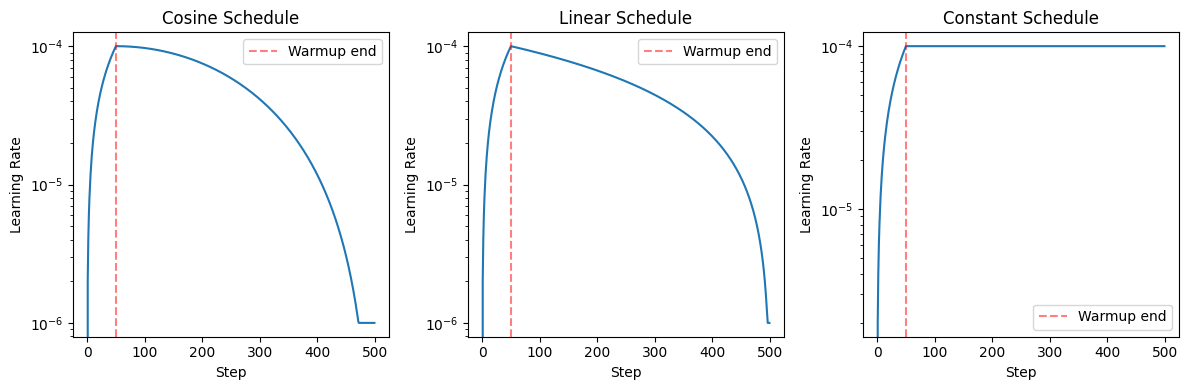

In [32]:
def visualise_lr_schedule(
    config: TrainerConfig,
    n_batches_per_epoch: int,
    figsize: Tuple[float, float] = (12, 4),
):
    """Visualise different learning rate schedules."""
    
    total_steps = n_batches_per_epoch * config.epochs
    warmup_steps = config.warmup_steps
    
    schedules = {}
    
    # Cosine schedule
    cosine_lrs = []
    for step in range(total_steps):
        if step < warmup_steps:
            lr = config.learning_rate * step / warmup_steps
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            cosine_decay = 0.5 * (1.0 + np.cos(np.pi * progress))
            lr = max(config.min_lr, config.learning_rate * cosine_decay)
        cosine_lrs.append(lr)
    schedules["cosine"] = cosine_lrs
    
    # Linear schedule
    linear_lrs = []
    for step in range(total_steps):
        if step < warmup_steps:
            lr = config.learning_rate * step / warmup_steps
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            lr = max(config.min_lr, config.learning_rate * (1 - progress))
        linear_lrs.append(lr)
    schedules["linear"] = linear_lrs
    
    # Constant with warmup
    constant_lrs = []
    for step in range(total_steps):
        if step < warmup_steps:
            lr = config.learning_rate * step / warmup_steps
        else:
            lr = config.learning_rate
        constant_lrs.append(lr)
    schedules["constant"] = constant_lrs
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    for ax, (name, lrs) in zip(axes, schedules.items()):
        ax.plot(lrs)
        ax.axvline(warmup_steps, color='r', linestyle='--', alpha=0.5, label='Warmup end')
        ax.set_xlabel("Step")
        ax.set_ylabel("Learning Rate")
        ax.set_title(f"{name.capitalize()} Schedule")
        ax.set_yscale('log')
        ax.legend()
    
    plt.tight_layout()
    save_figure(fig, FIGURES_DIR / "lr_schedules.png")
    plt.show()
    
    return schedules

# Visualise schedules
_ = visualise_lr_schedule(trainer_config, n_batches_per_epoch=len(loaders['train']))

### 6.5 Mixed Precision Training

In [33]:
print("Mixed Precision Training (AMP):")
print("-" * 40)
print("""
Benefits:
- ~2x faster training on modern GPUs (V100, A100, RTX 30xx/40xx)
- ~50% memory reduction
- Minimal accuracy impact

How it works:
1. Forward pass in FP16
2. Loss scaled to prevent underflow
3. Backward pass in FP16
4. Weights updated in FP32

Enabled automatically when:
- use_amp=True in TrainerConfig
- CUDA device is available
""")

print(f"\nAMP enabled: {trainer_config.use_amp and torch.cuda.is_available()}")

Mixed Precision Training (AMP):
----------------------------------------

Benefits:
- ~2x faster training on modern GPUs (V100, A100, RTX 30xx/40xx)
- ~50% memory reduction
- Minimal accuracy impact

How it works:
1. Forward pass in FP16
2. Loss scaled to prevent underflow
3. Backward pass in FP16
4. Weights updated in FP32

Enabled automatically when:
- use_amp=True in TrainerConfig
- CUDA device is available


AMP enabled: True


### 6.6 Gradient Accumulation

In [34]:
print("Gradient Accumulation:")
print("-" * 40)
print("""
Purpose: Simulate larger batch sizes without more GPU memory

Example:
- batch_size = 32
- gradient_accumulation_steps = 4
- effective_batch_size = 32 * 4 = 128

Use when:
- Limited GPU memory
- Want larger effective batch sizes for stability
- Training with very long protein sequences
""")

# Example calculation
batch_size = BATCH_SIZE
accum_steps = trainer_config.gradient_accumulation_steps
effective_batch = batch_size * accum_steps

print(f"\nCurrent settings:")
print(f"  Batch size: {batch_size}")
print(f"  Accumulation steps: {accum_steps}")
print(f"  Effective batch size: {effective_batch}")

Gradient Accumulation:
----------------------------------------

Purpose: Simulate larger batch sizes without more GPU memory

Example:
- batch_size = 32
- gradient_accumulation_steps = 4
- effective_batch_size = 32 * 4 = 128

Use when:
- Limited GPU memory
- Want larger effective batch sizes for stability
- Training with very long protein sequences


Current settings:
  Batch size: 32
  Accumulation steps: 1
  Effective batch size: 32


## 7. Callbacks

Callbacks provide hooks into the training loop for monitoring, checkpointing,
and early stopping.

### 7.1 CheckpointCallback

In [35]:
# Configure checkpointing
checkpoint_callback = CheckpointCallback(
    checkpoint_dir=CHECKPOINT_DIR / "protophen_demo",
    save_best=True,
    monitor="val_loss",
    mode="min",
    save_every_n_epochs=10,
    keep_n_checkpoints=3,
    save_weights_only=False,  # Save optimiser state too for resuming
)

print("CheckpointCallback configured:")
print(f"  Directory: {checkpoint_callback.checkpoint_dir}")
print(f"  Monitor: {checkpoint_callback.monitor}")
print(f"  Save best: {checkpoint_callback.save_best}")
print(f"  Keep N checkpoints: {checkpoint_callback.keep_n_checkpoints}")

CheckpointCallback configured:
  Directory: outputs\03_model_training\checkpoints\protophen_demo
  Monitor: val_loss
  Save best: True
  Keep N checkpoints: 3


### 7.2 EarlyStoppingCallback

In [36]:
# Configure early stopping
early_stopping_callback = EarlyStoppingCallback(
    monitor="val_loss",
    patience=10,
    min_delta=1e-4,
    mode="min",
    restore_best_weights=True,
)

print("EarlyStoppingCallback configured:")
print(f"  Monitor: {early_stopping_callback.monitor}")
print(f"  Patience: {early_stopping_callback.patience}")
print(f"  Min delta: {early_stopping_callback.min_delta}")
print(f"  Restore best weights: {early_stopping_callback.restore_best_weights}")

EarlyStoppingCallback configured:
  Monitor: val_loss
  Patience: 10
  Min delta: 0.0001
  Restore best weights: True


### 7.3 LoggingCallback

In [37]:
# Configure logging
logging_callback = LoggingCallback(
    log_every_n_steps=10,
    log_file=RESULTS_DIR / "training.log",
)

print("LoggingCallback configured:")
print(f"  Log every N steps: {logging_callback.log_every_n_steps}")
print(f"  Log file: {logging_callback.log_file}")

LoggingCallback configured:
  Log every N steps: 10
  Log file: outputs\03_model_training\results\training.log


### 7.4 Progress and TensorBoard Callbacks

In [38]:
# Progress bar callback
progress_callback = ProgressCallback()

# TensorBoard callback (optional)
tensorboard_callback = TensorBoardCallback(
    log_dir=RESULTS_DIR / "tensorboard",
    log_every_n_steps=10,
    log_histograms=False,  # Set True to log weight distributions
)

print("Additional callbacks configured:")
print("  - ProgressCallback (tqdm progress bars)")
print("  - TensorBoardCallback (run `tensorboard --logdir results/tensorboard`)")

Additional callbacks configured:
  - ProgressCallback (tqdm progress bars)
  - TensorBoardCallback (run `tensorboard --logdir results/tensorboard`)


### 7.5 Custom Callbacks

In [39]:
class GradientMonitorCallback(Callback):
    """
    Custom callback to monitor gradient statistics.
    
    Useful for debugging training issues like vanishing/exploding gradients.
    """
    
    def __init__(self, log_every_n_steps: int = 50):
        self.log_every_n_steps = log_every_n_steps
        self.gradient_norms: List[float] = []
    
    def on_batch_end(
        self,
        state: TrainingState,
        batch: Dict,
        outputs: Dict,
    ) -> None:
        if state.global_step % self.log_every_n_steps != 0:
            return
        
        # Compute total gradient norm
        total_norm = 0.0
        for param in self.trainer.model.parameters():
            if param.grad is not None:
                total_norm += param.grad.data.norm(2).item() ** 2
        total_norm = total_norm ** 0.5
        
        self.gradient_norms.append(total_norm)
        
        # Check for issues
        if total_norm > 100:
            print(f"   Large gradient norm: {total_norm:.2f} at step {state.global_step}")
        elif total_norm < 1e-7:
            print(f"   Very small gradient norm: {total_norm:.2e} at step {state.global_step}")

# Create gradient monitor
gradient_monitor = GradientMonitorCallback(log_every_n_steps=50)

In [40]:
# Another custom callback: Learning rate logging
class LRLoggerCallback(Callback):
    """Log learning rate at each epoch."""
    
    def __init__(self):
        self.lr_history: List[float] = []
    
    def on_epoch_end(self, state: TrainingState) -> None:
        lr = self.trainer.optimiser.param_groups[0]["lr"]
        self.lr_history.append(lr)
        print(f"  LR at epoch {state.epoch}: {lr:.2e}")

lr_logger = LRLoggerCallback()

### 7.6 Combining Callbacks

In [41]:
# Assemble all callbacks
callbacks = [
    logging_callback,
    progress_callback,
    checkpoint_callback,
    early_stopping_callback,
    gradient_monitor,
    lr_logger,
    # tensorboard_callback,  # Uncomment if you want TensorBoard logging
]

print(f"Total callbacks: {len(callbacks)}")
for cb in callbacks:
    print(f"  - {type(cb).__name__}")

Total callbacks: 6
  - LoggingCallback
  - ProgressCallback
  - CheckpointCallback
  - EarlyStoppingCallback
  - GradientMonitorCallback
  - LRLoggerCallback


## 8. Training Loop

Now we'll initialise the Trainer and run training.

### 8.1 Initialise Trainer

In [42]:
# Create loss function
loss_fn = create_loss_function(
    tasks=trainer_config.tasks,
    task_weights=trainer_config.task_weights,
    use_uncertainty_weighting=False,
    predict_aleatoric=model_config.predict_uncertainty,
    cell_painting_config={
        "mse_weight": 1.0,
        "correlation_weight": 0.1,  # Encourage correlated predictions
        "cosine_weight": 0.0,
    },
)

print(f"Loss function: {type(loss_fn).__name__}")
print(f"  Tasks: {trainer_config.tasks}")
print(f"  Weights: {trainer_config.task_weights}")

Loss function: CombinedLoss
  Tasks: ['cell_painting', 'viability']
  Weights: {'cell_painting': 1.0, 'viability': 0.5}


In [43]:
# Create metrics collection - one per task for proper handling of different output shapes
metrics = create_multitask_metrics(
    tasks=trainer_config.tasks,
    include_correlation=True,
)

print(f"Multi-task metrics created: {metrics}")
for task in trainer_config.tasks:
    task_metrics = metrics.get_task_metrics(task)
    if task_metrics:
        print(f"  {task}: {[m.name for m in task_metrics.metrics]}")

Multi-task metrics created: MultiTaskMetricCollection(cell_painting: 6 metrics, viability: 6 metrics)
  cell_painting: ['mse', 'mae', 'rmse', 'r2', 'pearson', 'cosine_similarity']
  viability: ['mse', 'mae', 'rmse', 'r2', 'pearson', 'cosine_similarity']


In [44]:
# Initialise trainer
trainer = Trainer(
    model=model,
    train_loader=loaders['train'],
    val_loader=loaders['val'],
    config=trainer_config,
    loss_fn=loss_fn,
    callbacks=callbacks,
    metrics=metrics,
)

print("\nTrainer initialised successfully.")
print(f"  Device: {trainer.device}")
print(f"  Epochs: {trainer.config.epochs}")
print(f"  Callbacks: {len(trainer.callbacks)}")

2026-02-15 23:34:26 | INFO     | protophen.training.trainer:__init__:230 | Trainer initialised: device=cuda, epochs=50, lr=0.0001, amp=True



Trainer initialised successfully.
  Device: cuda
  Epochs: 50
  Callbacks: 6


### 8.2 Alternative: Quick Trainer Creation

In [45]:
# For simple cases, use the convenience function
quick_trainer = create_trainer(
    model=model,
    train_loader=loaders['train'],
    val_loader=loaders['val'],
    learning_rate=1e-4,
    epochs=50,
    device=str(DEVICE),
    checkpoint_dir=CHECKPOINT_DIR / "quick_run",
    early_stopping_patience=10,
    use_tensorboard=False,
)

print("Quick trainer created with defaults")

2026-02-15 23:34:26 | INFO     | protophen.training.trainer:__init__:230 | Trainer initialised: device=cuda, epochs=50, lr=0.0001, amp=True


Quick trainer created with defaults


### 8.3 Run Training

In [46]:
# Train the model
print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)

history = trainer.train(epochs=trainer_config.epochs)

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)

STARTING TRAINING


Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

2026-02-15 23:34:26 | INFO     | protophen.training.callbacks:on_train_begin:218 | Checkpoints will be saved to outputs\03_model_training\checkpoints\protophen_demo
2026-02-15 23:34:26 | INFO     | protophen.training.trainer:train:654 | Starting training for 50 epochs


Epoch 1:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:27 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 10 | Epoch 1 | Loss: 1.2972 | LR: 2.00e-05
2026-02-15 23:34:42 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.1411 | cell_painting_mae: 0.8550 | cell_painting_rmse: 1.0682 | cell_painting_r2: -0.1363 | cell_painting_pearson: -0.0054 | cell_painting_cosine_similarity: -0.0055 | viability_mse: 0.0866 | viability_mae: 0.2593 | viability_rmse: 0.2943 | viability_r2: -0.0817 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.2886
2026-02-15 23:34:42 | INFO     | protophen.training.callbacks:on_validation_end:251 | New best model saved: val_loss=1.288567
2026-02-15 23:34:42 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 1 completed in 16.0s | Avg Loss: 1.2972


  LR at epoch 1: 2.00e-05


Epoch 2:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:42 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 20 | Epoch 2 | Loss: 1.2735 | LR: 4.00e-05
2026-02-15 23:34:42 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.1172 | cell_painting_mae: 0.8460 | cell_painting_rmse: 1.0570 | cell_painting_r2: -0.1125 | cell_painting_pearson: -0.0060 | cell_painting_cosine_similarity: -0.0061 | viability_mse: 0.0851 | viability_mae: 0.2597 | viability_rmse: 0.2917 | viability_r2: -0.0633 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.2634
2026-02-15 23:34:42 | INFO     | protophen.training.callbacks:on_validation_end:251 | New best model saved: val_loss=1.263446
2026-02-15 23:34:42 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 2 completed in 0.5s | Avg Loss: 1.2735


  LR at epoch 2: 4.00e-05


Epoch 3:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 30 | Epoch 3 | Loss: 1.2431 | LR: 6.00e-05
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0912 | cell_painting_mae: 0.8363 | cell_painting_rmse: 1.0446 | cell_painting_r2: -0.0866 | cell_painting_pearson: -0.0072 | cell_painting_cosine_similarity: -0.0073 | viability_mse: 0.0855 | viability_mae: 0.2612 | viability_rmse: 0.2924 | viability_r2: -0.0681 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.2372
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_validation_end:251 | New best model saved: val_loss=1.237240
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 3 completed in 0.3s | Avg Loss: 1.2431


  LR at epoch 3: 6.00e-05


Epoch 4:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 40 | Epoch 4 | Loss: 1.2040 | LR: 8.00e-05
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0701 | cell_painting_mae: 0.8284 | cell_painting_rmse: 1.0345 | cell_painting_r2: -0.0656 | cell_painting_pearson: -0.0094 | cell_painting_cosine_similarity: -0.0095 | viability_mse: 0.0849 | viability_mae: 0.2607 | viability_rmse: 0.2915 | viability_r2: -0.0612 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.2163
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_validation_end:251 | New best model saved: val_loss=1.216340
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 4 completed in 0.2s | Avg Loss: 1.2040


  LR at epoch 4: 8.00e-05


Epoch 5:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 50 | Epoch 5 | Loss: 1.1707 | LR: 1.00e-04
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0533 | cell_painting_mae: 0.8219 | cell_painting_rmse: 1.0263 | cell_painting_r2: -0.0488 | cell_painting_pearson: -0.0121 | cell_painting_cosine_similarity: -0.0122 | viability_mse: 0.0849 | viability_mae: 0.2602 | viability_rmse: 0.2914 | viability_r2: -0.0606 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.2002


   Very small gradient norm: 0.00e+00 at step 50


2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_validation_end:251 | New best model saved: val_loss=1.200193
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 5 completed in 0.2s | Avg Loss: 1.1707


  LR at epoch 5: 1.00e-04


Epoch 6:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 60 | Epoch 6 | Loss: 1.1423 | LR: 9.99e-05
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0414 | cell_painting_mae: 0.8174 | cell_painting_rmse: 1.0205 | cell_painting_r2: -0.0370 | cell_painting_pearson: -0.0148 | cell_painting_cosine_similarity: -0.0149 | viability_mse: 0.0849 | viability_mae: 0.2586 | viability_rmse: 0.2913 | viability_r2: -0.0601 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1889
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_validation_end:251 | New best model saved: val_loss=1.188917
2026-02-15 23:34:43 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 6 completed in 0.2s | Avg Loss: 1.1423


  LR at epoch 6: 9.99e-05


Epoch 7:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 70 | Epoch 7 | Loss: 1.1218 | LR: 9.95e-05
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0343 | cell_painting_mae: 0.8145 | cell_painting_rmse: 1.0170 | cell_painting_r2: -0.0300 | cell_painting_pearson: -0.0152 | cell_painting_cosine_similarity: -0.0153 | viability_mse: 0.0856 | viability_mae: 0.2571 | viability_rmse: 0.2925 | viability_r2: -0.0692 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1822
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_validation_end:251 | New best model saved: val_loss=1.182184
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 7 completed in 0.2s | Avg Loss: 1.1218


  LR at epoch 7: 9.95e-05


Epoch 8:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 80 | Epoch 8 | Loss: 1.1058 | LR: 9.89e-05
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0298 | cell_painting_mae: 0.8127 | cell_painting_rmse: 1.0148 | cell_painting_r2: -0.0254 | cell_painting_pearson: -0.0119 | cell_painting_cosine_similarity: -0.0120 | viability_mse: 0.0872 | viability_mae: 0.2570 | viability_rmse: 0.2953 | viability_r2: -0.0895 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1786
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_validation_end:251 | New best model saved: val_loss=1.178567
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 8 completed in 0.2s | Avg Loss: 1.1058


  LR at epoch 8: 9.89e-05


Epoch 9:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 90 | Epoch 9 | Loss: 1.0911 | LR: 9.81e-05
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0274 | cell_painting_mae: 0.8118 | cell_painting_rmse: 1.0136 | cell_painting_r2: -0.0231 | cell_painting_pearson: -0.0070 | cell_painting_cosine_similarity: -0.0071 | viability_mse: 0.0890 | viability_mae: 0.2568 | viability_rmse: 0.2983 | viability_r2: -0.1115 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1768
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_validation_end:251 | New best model saved: val_loss=1.176840
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 9 completed in 0.2s | Avg Loss: 1.0911


  LR at epoch 9: 9.81e-05


Epoch 10:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 100 | Epoch 10 | Loss: 1.0803 | LR: 9.70e-05
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0283 | cell_painting_mae: 0.8122 | cell_painting_rmse: 1.0141 | cell_painting_r2: -0.0240 | cell_painting_pearson: -0.0070 | cell_painting_cosine_similarity: -0.0071 | viability_mse: 0.0892 | viability_mae: 0.2548 | viability_rmse: 0.2987 | viability_r2: -0.1150 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1779
2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 10 completed in 0.2s | Avg Loss: 1.0803


   Very small gradient norm: 0.00e+00 at step 100
  LR at epoch 10: 9.70e-05


Epoch 11:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:44 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 110 | Epoch 11 | Loss: 1.0630 | LR: 9.57e-05
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0296 | cell_painting_mae: 0.8127 | cell_painting_rmse: 1.0147 | cell_painting_r2: -0.0252 | cell_painting_pearson: -0.0040 | cell_painting_cosine_similarity: -0.0041 | viability_mse: 0.0908 | viability_mae: 0.2550 | viability_rmse: 0.3014 | viability_r2: -0.1346 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1789
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 11 completed in 0.2s | Avg Loss: 1.0630


  LR at epoch 11: 9.57e-05


Epoch 12:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 120 | Epoch 12 | Loss: 1.0505 | LR: 9.41e-05
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0302 | cell_painting_mae: 0.8130 | cell_painting_rmse: 1.0150 | cell_painting_r2: -0.0258 | cell_painting_pearson: 0.0020 | cell_painting_cosine_similarity: 0.0019 | viability_mse: 0.0916 | viability_mae: 0.2559 | viability_rmse: 0.3027 | viability_r2: -0.1449 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1785
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 12 completed in 0.2s | Avg Loss: 1.0505


  LR at epoch 12: 9.41e-05


Epoch 13:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 130 | Epoch 13 | Loss: 1.0347 | LR: 9.24e-05
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0330 | cell_painting_mae: 0.8141 | cell_painting_rmse: 1.0163 | cell_painting_r2: -0.0286 | cell_painting_pearson: 0.0039 | cell_painting_cosine_similarity: 0.0038 | viability_mse: 0.0922 | viability_mae: 0.2556 | viability_rmse: 0.3037 | viability_r2: -0.1525 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1816
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 13 completed in 0.2s | Avg Loss: 1.0347


  LR at epoch 13: 9.24e-05


Epoch 14:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 140 | Epoch 14 | Loss: 1.0175 | LR: 9.05e-05
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0361 | cell_painting_mae: 0.8154 | cell_painting_rmse: 1.0179 | cell_painting_r2: -0.0318 | cell_painting_pearson: 0.0079 | cell_painting_cosine_similarity: 0.0078 | viability_mse: 0.0951 | viability_mae: 0.2596 | viability_rmse: 0.3083 | viability_r2: -0.1875 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1859
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 14 completed in 0.2s | Avg Loss: 1.0175


  LR at epoch 14: 9.05e-05


Epoch 15:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 150 | Epoch 15 | Loss: 1.0002 | LR: 8.83e-05
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0393 | cell_painting_mae: 0.8166 | cell_painting_rmse: 1.0195 | cell_painting_r2: -0.0350 | cell_painting_pearson: 0.0112 | cell_painting_cosine_similarity: 0.0111 | viability_mse: 0.0944 | viability_mae: 0.2577 | viability_rmse: 0.3073 | viability_r2: -0.1799 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1884
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 15 completed in 0.2s | Avg Loss: 1.0002


   Very small gradient norm: 0.00e+00 at step 150
  LR at epoch 15: 8.83e-05


Epoch 16:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 160 | Epoch 16 | Loss: 0.9844 | LR: 8.60e-05
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0420 | cell_painting_mae: 0.8177 | cell_painting_rmse: 1.0208 | cell_painting_r2: -0.0376 | cell_painting_pearson: 0.0155 | cell_painting_cosine_similarity: 0.0154 | viability_mse: 0.0944 | viability_mae: 0.2568 | viability_rmse: 0.3073 | viability_r2: -0.1796 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1903
2026-02-15 23:34:45 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 16 completed in 0.2s | Avg Loss: 0.9844


  LR at epoch 16: 8.60e-05


Epoch 17:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:46 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 170 | Epoch 17 | Loss: 0.9640 | LR: 8.35e-05
2026-02-15 23:34:46 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0455 | cell_painting_mae: 0.8190 | cell_painting_rmse: 1.0225 | cell_painting_r2: -0.0411 | cell_painting_pearson: 0.0193 | cell_painting_cosine_similarity: 0.0192 | viability_mse: 0.0965 | viability_mae: 0.2598 | viability_rmse: 0.3106 | viability_r2: -0.2051 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1939
2026-02-15 23:34:46 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 17 completed in 0.2s | Avg Loss: 0.9640


  LR at epoch 17: 8.35e-05


Epoch 18:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:46 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 180 | Epoch 18 | Loss: 0.9460 | LR: 8.08e-05
2026-02-15 23:34:46 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0489 | cell_painting_mae: 0.8203 | cell_painting_rmse: 1.0242 | cell_painting_r2: -0.0445 | cell_painting_pearson: 0.0231 | cell_painting_cosine_similarity: 0.0230 | viability_mse: 0.0980 | viability_mae: 0.2618 | viability_rmse: 0.3130 | viability_r2: -0.2241 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.1975
2026-02-15 23:34:46 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 18 completed in 0.2s | Avg Loss: 0.9460


  LR at epoch 18: 8.08e-05


Epoch 19:   0%|          | 0/10 [00:00<?, ?batch/s]

2026-02-15 23:34:46 | INFO     | protophen.training.callbacks:on_batch_end:498 | Step 190 | Epoch 19 | Loss: 0.9258 | LR: 7.80e-05
2026-02-15 23:34:46 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 1.0528 | cell_painting_mae: 0.8218 | cell_painting_rmse: 1.0261 | cell_painting_r2: -0.0484 | cell_painting_pearson: 0.0266 | cell_painting_cosine_similarity: 0.0266 | viability_mse: 0.0964 | viability_mae: 0.2580 | viability_rmse: 0.3105 | viability_r2: -0.2044 | viability_pearson: 0.0000 | viability_cosine_similarity: 1.0000 | val_loss: 1.2008
2026-02-15 23:34:46 | INFO     | protophen.training.callbacks:on_validation_end:417 | Early stopping triggered at epoch 19. Best val_loss: 1.176840
2026-02-15 23:34:46 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 19 completed in 0.2s | Avg Loss: 0.9258
2026-02-15 23:34:46 | INFO     | protophen.training.trainer:train:662 | Early stopping triggered
2026-02-15 23:34:46 | INFO     

  LR at epoch 19: 7.80e-05

TRAINING COMPLETE


### 8.4 Training History Visualisation

2026-02-15 23:34:46 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\training_history.png


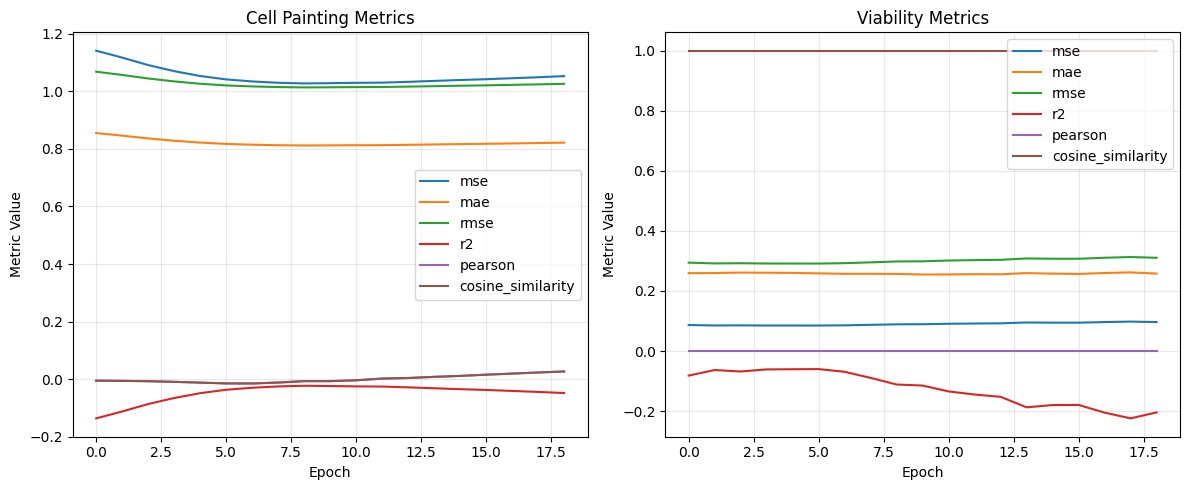

In [47]:
# Plot training history
# Plot per-task metrics from validation history
if history['val_metrics']:
    # Extract metric names from first validation result
    first_metrics = history['val_metrics'][0]
    
    # Group metrics by task
    task_metric_names = {}
    for task in trainer_config.tasks:
        task_metric_names[task] = [
            key for key in first_metrics.keys() 
            if key.startswith(f"{task}_")
        ]
    
    # Create subplot for each task
    n_tasks = len(trainer_config.tasks)
    fig, axes = plt.subplots(1, n_tasks, figsize=(6 * n_tasks, 5))
    if n_tasks == 1:
        axes = [axes]
    
    for ax, task in zip(axes, trainer_config.tasks):
        metric_names = task_metric_names.get(task, [])
        
        for metric_name in metric_names:
            if metric_name == "val_loss":
                continue
            values = [m.get(metric_name, 0) for m in history['val_metrics']]
            # Shorten the label by removing task prefix
            short_name = metric_name.replace(f"{task}_", "")
            ax.plot(values, label=short_name)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Metric Value')
        ax.set_title(f'{task.replace("_", " ").title()} Metrics')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_figure(fig, FIGURES_DIR / "training_history.png")
    plt.show()

2026-02-15 23:34:47 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\loss_curves.png


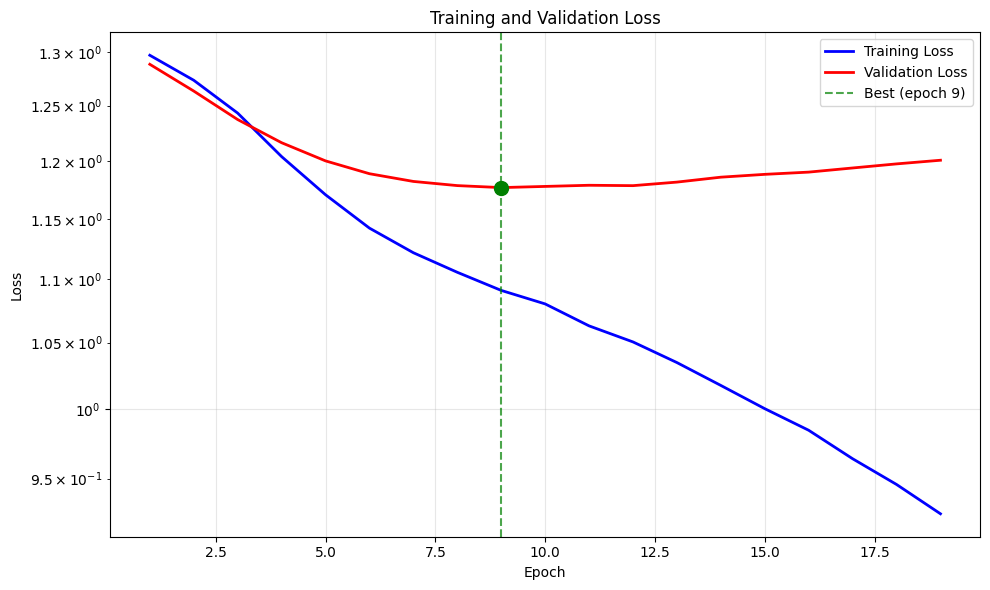


Best validation loss: 1.176840 at epoch 9


In [48]:
# Plot loss curves in detail
fig, ax = plt.subplots(figsize=(10, 6))

epochs = range(1, len(history['train_losses']) + 1)
ax.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2)
ax.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2)

# Mark best epoch
best_epoch = np.argmin(history['val_losses']) + 1
best_val_loss = min(history['val_losses'])
ax.axvline(best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best (epoch {best_epoch})')
ax.scatter([best_epoch], [best_val_loss], color='g', s=100, zorder=5)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Log scale for better visualisation
ax.set_yscale('log')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "loss_curves.png")
plt.show()

print(f"\nBest validation loss: {best_val_loss:.6f} at epoch {best_epoch}")

2026-02-15 23:34:47 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\lr_history.png


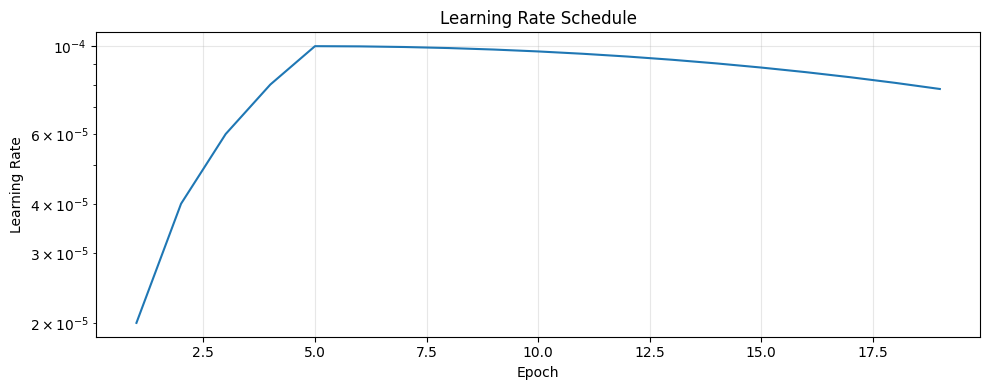

In [49]:
# Plot learning rate history
if hasattr(lr_logger, 'lr_history') and lr_logger.lr_history:
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.plot(range(1, len(lr_logger.lr_history) + 1), lr_logger.lr_history)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rate Schedule')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_figure(fig, FIGURES_DIR / "lr_history.png")
    plt.show()

2026-02-15 23:34:47 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\gradient_norm.png


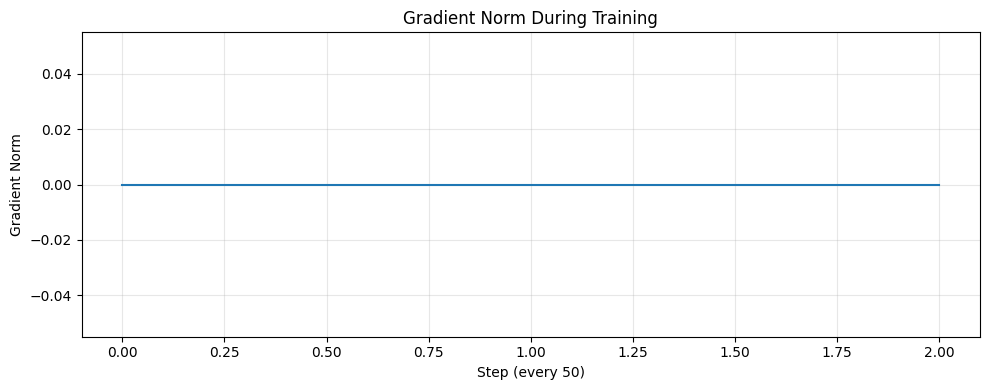

Mean gradient norm: 0.0000
Max gradient norm:  0.0000


In [50]:
# Plot gradient norms
if hasattr(gradient_monitor, 'gradient_norms') and gradient_monitor.gradient_norms:
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.plot(gradient_monitor.gradient_norms)
    ax.set_xlabel('Step (every 50)')
    ax.set_ylabel('Gradient Norm')
    ax.set_title('Gradient Norm During Training')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_figure(fig, FIGURES_DIR / "gradient_norm.png")
    plt.show()
    
    print(f"Mean gradient norm: {np.mean(gradient_monitor.gradient_norms):.4f}")
    print(f"Max gradient norm:  {np.max(gradient_monitor.gradient_norms):.4f}")

## 9. Evaluation

Now we'll evaluate the trained model on the held-out test set.

### 9.1 Predict on Test Set

In [51]:
# Get predictions on test set
results = trainer.predict(
    dataloader=loaders['test'],
    return_targets=True,
)

print("Prediction results:")
for key in results:
    if isinstance(results[key], np.ndarray):
        print(f"  {key}: {results[key].shape}")
    else:
        print(f"  {key}: {type(results[key]).__name__}[{len(results[key])}]")

Prediction results:
  protein_ids: list[75]
  cell_painting_predictions: (75, 1500)
  cell_painting_targets: (75, 1500)
  viability_predictions: (75, 1)
  viability_targets: (75, 1)


In [52]:
# Extract predictions and targets
cell_painting_pred = results['cell_painting_predictions']
cell_painting_true = results['cell_painting_targets']

print(f"\nCell Painting predictions: {cell_painting_pred.shape}")
print(f"Cell Painting targets:     {cell_painting_true.shape}")


Cell Painting predictions: (75, 1500)
Cell Painting targets:     (75, 1500)


### 9.2 Compute Metrics

In [53]:
# Compute overall metrics
overall_metrics = compute_regression_metrics(
    predictions=cell_painting_pred,
    targets=cell_painting_true,
)

print("\nOverall Test Metrics:")
print("-" * 40)
for name, value in overall_metrics.items():
    print(f"  {name:20s}: {value:.4f}")


Overall Test Metrics:
----------------------------------------
  mse                 : 1.0371
  mae                 : 0.8155
  rmse                : 1.0184
  r2                  : -0.0215
  pearson             : -0.0019
  cosine_similarity   : -0.0019


### 9.3 Per-Feature Metrics

In [54]:
# Compute metrics for each feature
feature_metrics = compute_per_feature_metrics(
    predictions=cell_painting_pred,
    targets=cell_painting_true,
)

# Summarise
summary = summarise_per_feature_metrics(feature_metrics)

print("\nPer-Feature Metrics Summary:")
print("-" * 40)
for name, value in summary.items():
    print(f"  {name:20s}: {value:.4f}")


Per-Feature Metrics Summary:
----------------------------------------
  mse_mean            : 1.0371
  mse_median          : 1.0321
  mse_std             : 0.1561
  mse_min             : 0.5260
  mse_max             : 1.6403
  r2_mean             : -0.0315
  r2_median           : -0.0285
  r2_std              : 0.0394
  r2_min              : -0.1930
  r2_max              : 0.0824
  pearson_mean        : 0.0109
  pearson_median      : 0.0172
  pearson_std         : 0.1180
  pearson_min         : -0.3169
  pearson_max         : 0.4070


2026-02-15 23:35:04 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\r2_plots.png


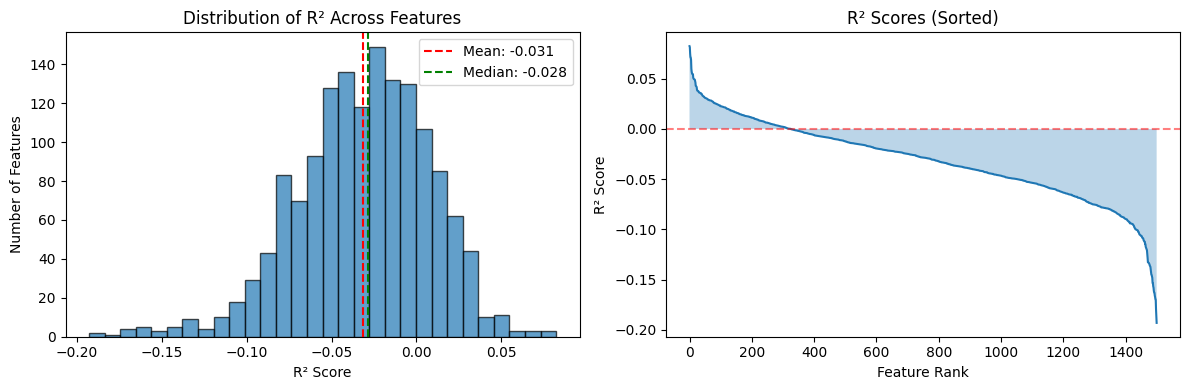


Feature statistics:
  Features with R² > 0:   325/1500 (21.7%)
  Features with R² > 0.5: 0/1500 (0.0%)


In [55]:
# Distribution of R² across features
r2_values = [m['r2'] for m in feature_metrics.values()]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(r2_values, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(r2_values), color='r', linestyle='--', label=f'Mean: {np.mean(r2_values):.3f}')
axes[0].axvline(np.median(r2_values), color='g', linestyle='--', label=f'Median: {np.median(r2_values):.3f}')
axes[0].set_xlabel('R² Score')
axes[0].set_ylabel('Number of Features')
axes[0].set_title('Distribution of R² Across Features')
axes[0].legend()

# Sorted R² values
sorted_r2 = np.sort(r2_values)[::-1]
axes[1].plot(sorted_r2)
axes[1].axhline(0, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Feature Rank')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² Scores (Sorted)')
axes[1].fill_between(range(len(sorted_r2)), sorted_r2, alpha=0.3)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "r2_plots.png")
plt.show()

# Statistics
n_positive = sum(1 for r2 in r2_values if r2 > 0)
n_high = sum(1 for r2 in r2_values if r2 > 0.5)

print(f"\nFeature statistics:")
print(f"  Features with R² > 0:   {n_positive}/{len(r2_values)} ({100*n_positive/len(r2_values):.1f}%)")
print(f"  Features with R² > 0.5: {n_high}/{len(r2_values)} ({100*n_high/len(r2_values):.1f}%)")

### 9.4 Visualise Predictions vs Targets

2026-02-15 23:35:05 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\best_predicted_features.png


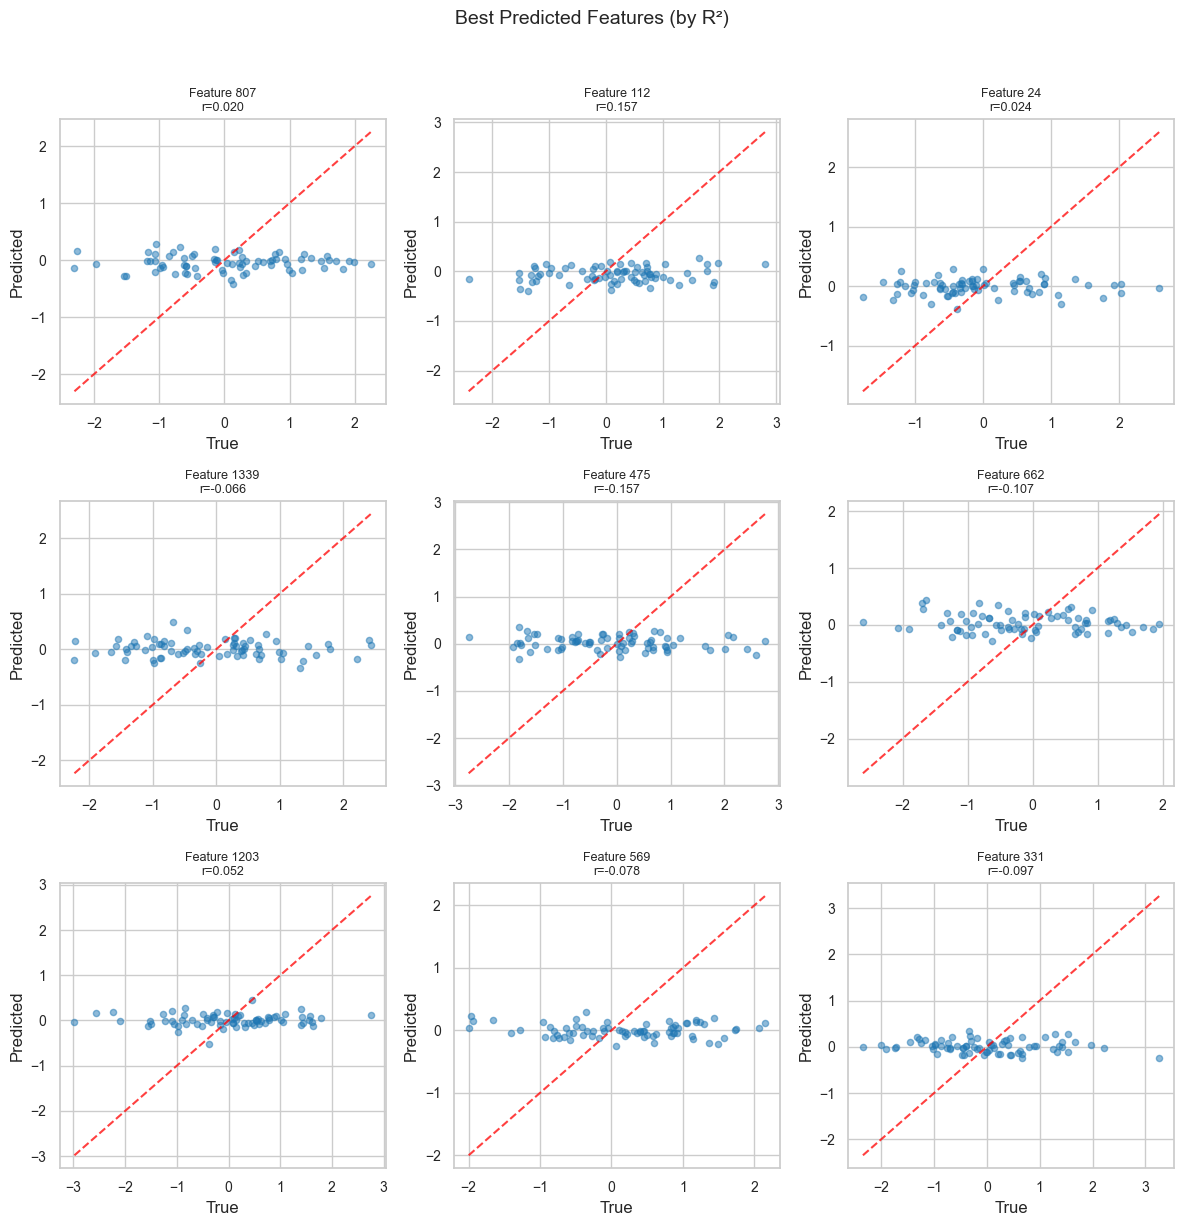

In [56]:
# Select features to visualise (best performing)
best_features = sorted(feature_metrics.items(), key=lambda x: x[1]['r2'], reverse=True)[:9]
best_feature_indices = [int(name.split('_')[1]) for name, _ in best_features]

fig, axes = plot_prediction_scatter(
    y_true=cell_painting_true,
    y_pred=cell_painting_pred,
    feature_names=[f"Feature {i}" for i in best_feature_indices],
    n_features=9,
    title="Best Predicted Features (by R²)",
    figsize=(12, 12),
)
save_figure(fig, FIGURES_DIR / "best_predicted_features.png")
plt.show()

2026-02-15 23:35:06 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\worst_predicted_features.png


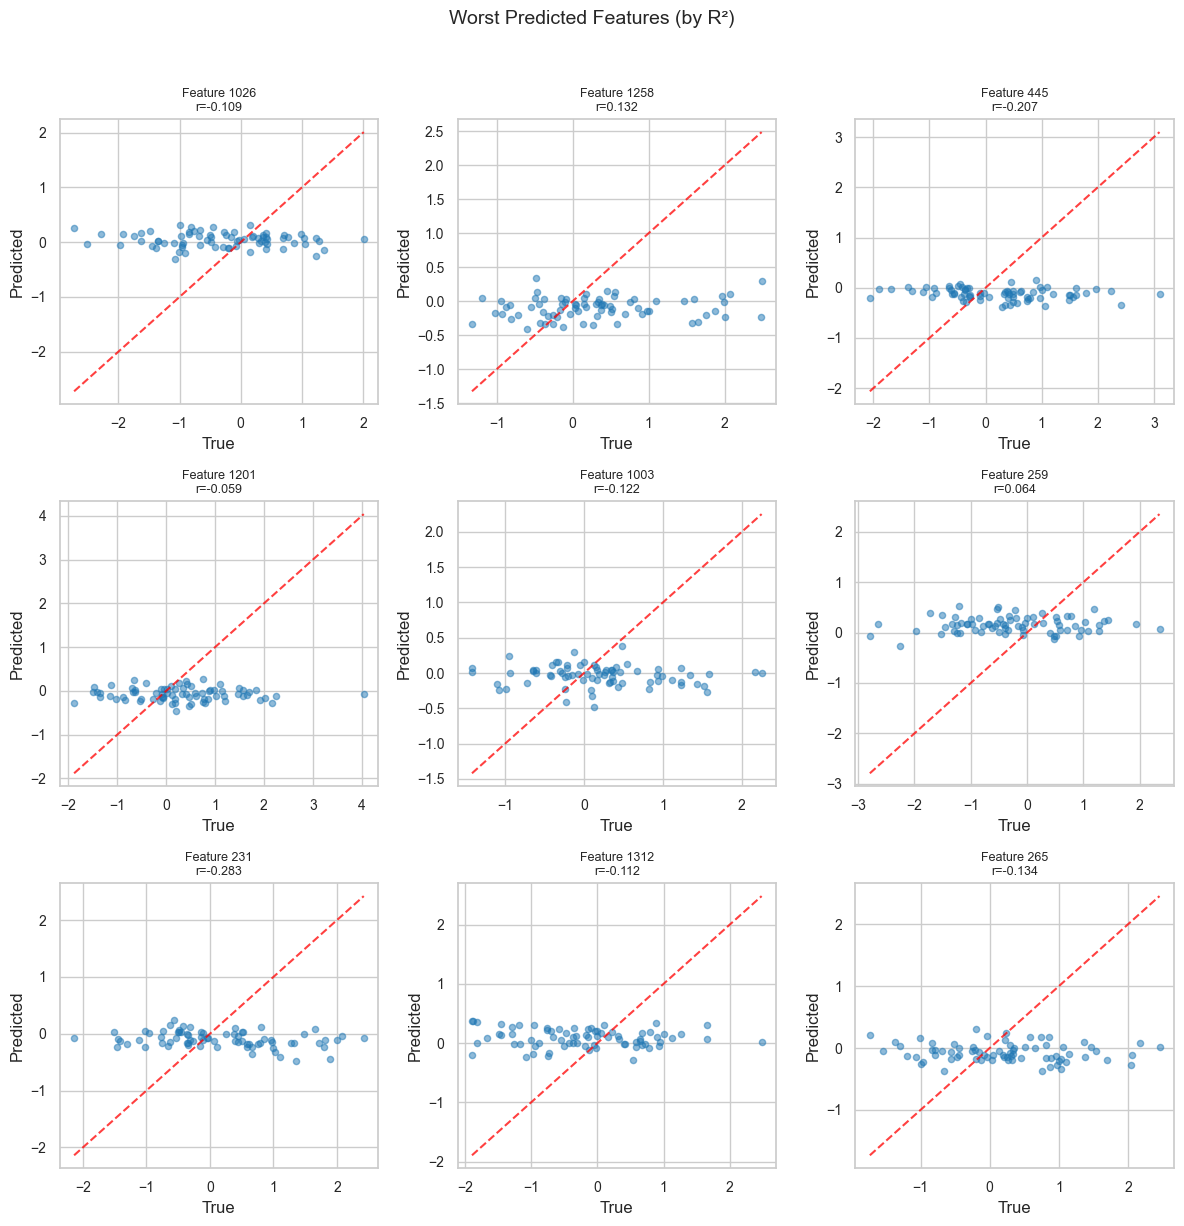

In [57]:
# Also show some poorly predicted features
worst_features = sorted(feature_metrics.items(), key=lambda x: x[1]['r2'])[:9]
worst_feature_indices = [int(name.split('_')[1]) for name, _ in worst_features]

fig, axes = plot_prediction_scatter(
    y_true=cell_painting_true[:, worst_feature_indices],
    y_pred=cell_painting_pred[:, worst_feature_indices],
    feature_names=[f"Feature {i}" for i in worst_feature_indices],
    n_features=9,
    title="Worst Predicted Features (by R²)",
    figsize=(12, 12),
)
save_figure(fig, FIGURES_DIR / "worst_predicted_features.png")
plt.show()

### 9.5 Residual Analysis

2026-02-15 23:35:07 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\best_feature_residuals.png


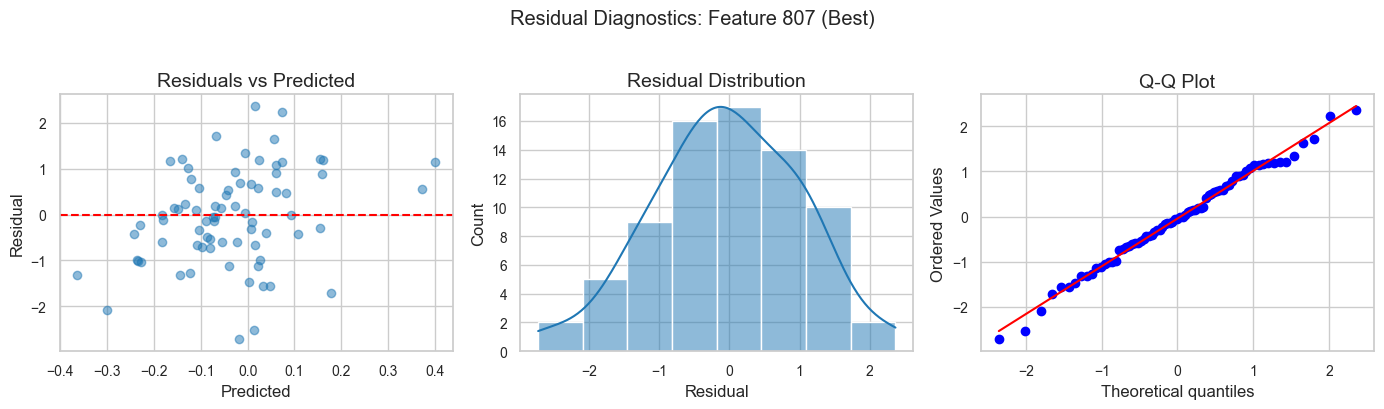

In [58]:
# Analyse residuals for a well-predicted feature
best_idx = best_feature_indices[0]

fig, axes = plot_residuals(
    y_true=cell_painting_true,
    y_pred=cell_painting_pred,
    feature_idx=best_idx,
    feature_name=f"Feature {best_idx} (Best)",
    figsize=(14, 4),
)
save_figure(fig, FIGURES_DIR / "best_feature_residuals.png")
plt.show()

### 9.6 Viability Prediction (if trained)

Viability Prediction Metrics:
----------------------------------------
  mse                 : 0.0954
  mae                 : 0.2702
  rmse                : 0.3089
  r2                  : -0.2303
  pearson             : -0.0948
  cosine_similarity   : 0.8603


2026-02-15 23:35:08 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\viability_prediction.png


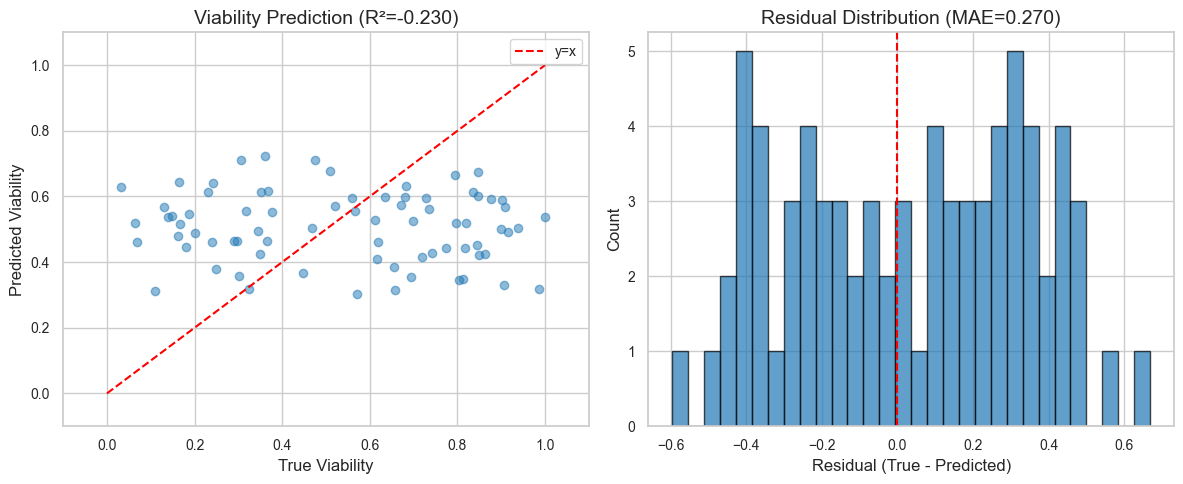

In [59]:
# Check if viability predictions are available
if 'viability_predictions' in results and 'viability_targets' in results:
    viability_pred = results['viability_predictions'].flatten()
    viability_true = results['viability_targets'].flatten()
    
    # Compute metrics
    viability_metrics = compute_regression_metrics(
        predictions=torch.tensor(viability_pred),
        targets=torch.tensor(viability_true),
    )
    
    print("Viability Prediction Metrics:")
    print("-" * 40)
    for name, value in viability_metrics.items():
        print(f"  {name:20s}: {value:.4f}")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot
    axes[0].scatter(viability_true, viability_pred, alpha=0.5)
    axes[0].plot([0, 1], [0, 1], 'r--', label='y=x')
    axes[0].set_xlabel('True Viability')
    axes[0].set_ylabel('Predicted Viability')
    axes[0].set_title(f'Viability Prediction (R²={viability_metrics["r2"]:.3f})')
    axes[0].legend()
    axes[0].set_xlim(-0.1, 1.1)
    axes[0].set_ylim(-0.1, 1.1)
    
    # Residual histogram
    residuals = viability_true - viability_pred
    axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='r', linestyle='--')
    axes[1].set_xlabel('Residual (True - Predicted)')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Residual Distribution (MAE={viability_metrics["mae"]:.3f})')
    
    plt.tight_layout()
    save_figure(fig, FIGURES_DIR / "viability_prediction.png")
    plt.show()
else:
    print("Viability predictions not available in results")

### 9.7 Latent Space Analysis

In [60]:
# Extract latent representations for test set
model.eval()
latent_representations = []
protein_ids_test = []

with torch.no_grad():
    for batch in loaders['test']:
        embeddings = batch['protein_embedding'].to(DEVICE)
        latent = model.get_latent(embeddings)
        latent_representations.append(latent.cpu().numpy())
        protein_ids_test.extend(batch['protein_id'])

latent_representations = np.concatenate(latent_representations, axis=0)
print(f"Latent representations shape: {latent_representations.shape}")

Latent representations shape: (75, 256)


2026-02-15 23:35:22 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\03_model_training\figures\latent_space_umap.png


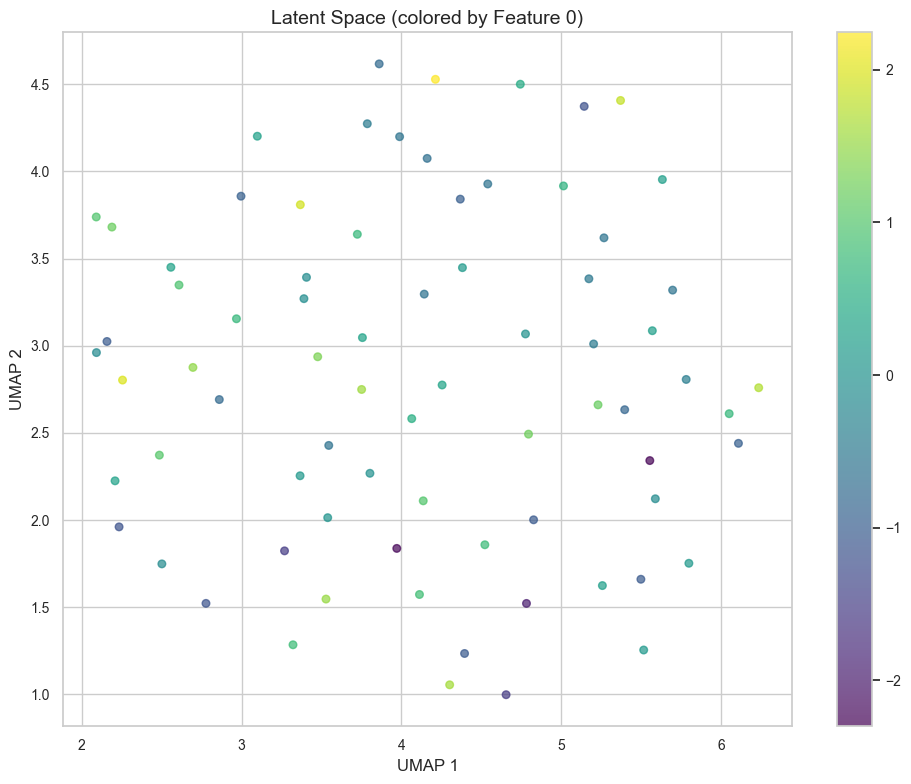

In [61]:
# Visualise latent space with UMAP
try:
    fig, ax = plot_embedding_space(
        embeddings=latent_representations,
        method="umap",
        color_by=cell_painting_true[:, 0],  # Color by first phenotype feature
        title="Latent Space (colored by Feature 0)",
    )
    save_figure(fig, FIGURES_DIR / "latent_space_umap.png")
    plt.show()
except ImportError:
    print("UMAP not available. Install with: pip install umap-learn")
    
    # Fallback to PCA
    fig, ax = plot_embedding_space(
        embeddings=latent_representations,
        method="pca",
        color_by=cell_painting_true[:, 0],
        title="Latent Space - PCA (colored by Feature 0)",
    )
    save_figure(fig, FIGURES_DIR / "latent_space_pca.png")
    plt.show()

## 10. Saving and Loading Models

Proper model checkpointing is essential for reproducibility and deployment.

### 10.1 Save Checkpoint

In [62]:
# Save full training checkpoint (includes optimiser state)
checkpoint_path = CHECKPOINT_DIR / "protophen_demo" / "final_model.pt"
trainer.save_checkpoint(checkpoint_path)

print(f"Checkpoint saved to: {checkpoint_path}")

2026-02-15 23:35:23 | INFO     | protophen.training.trainer:save_checkpoint:759 | Saved checkpoint to outputs\03_model_training\checkpoints\protophen_demo\final_model.pt


Checkpoint saved to: outputs\03_model_training\checkpoints\protophen_demo\final_model.pt


In [63]:
# Alternative: Save only model weights (smaller file)
weights_path = CHECKPOINT_DIR / "protophen_demo" / "model_weights.pt"
weights_path.parent.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), weights_path)
print(f"Model weights saved to: {weights_path}")
print(f"  File size: {weights_path.stat().st_size / 1e6:.2f} MB")

Model weights saved to: outputs\03_model_training\checkpoints\protophen_demo\model_weights.pt
  File size: 18.65 MB


In [64]:
# Save model configuration for reproducibility
config_path = CHECKPOINT_DIR / "protophen_demo" / "model_config.json"

from dataclasses import asdict

config_dict = asdict(model_config)
# Convert any non-serialisable items
config_dict = {k: v if isinstance(v, (int, float, str, bool, list, dict, type(None))) 
               else str(v) for k, v in config_dict.items()}

with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=2)

print(f"Model config saved to: {config_path}")

Model config saved to: outputs\03_model_training\checkpoints\protophen_demo\model_config.json


### 10.2 Load for Inference

In [65]:
def load_model_for_inference(
    checkpoint_path: Path,
    config: Optional[ProToPhenConfig] = None,
    device: str = "cuda",
) -> ProToPhenModel:
    """
    Load a trained model for inference.
    
    Args:
        checkpoint_path: Path to checkpoint file
        config: Model configuration (if not in checkpoint)
        device: Device to load model on
        
    Returns:
        Loaded model in eval mode
    """
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    
    # Reconstruct config if saved in checkpoint
    if config is None and 'config' in checkpoint:
        saved_config = checkpoint['config']
        # Handle TrainerConfig vs ProToPhenConfig
        if 'protein_embedding_dim' in saved_config:
            config = ProToPhenConfig(**saved_config)
        else:
            # Need to create config manually
            raise ValueError("Model config not found in checkpoint. Please provide config.")
    
    # Create model
    model = ProToPhenModel(config)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Move to device and set to eval mode
    model = model.to(device)
    model.eval()
    
    print(f"Model loaded from {checkpoint_path}")
    print(f"  Epoch: {checkpoint.get('epoch', 'unknown')}")
    print(f"  Best val loss: {checkpoint.get('best_val_loss', 'unknown')}")
    
    return model

# Load the saved model
loaded_model = load_model_for_inference(
    checkpoint_path=checkpoint_path,
    config=model_config,
    device=str(DEVICE),
)

2026-02-15 23:35:23 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Model loaded from outputs\03_model_training\checkpoints\protophen_demo\final_model.pt
  Epoch: 20
  Best val loss: 1.17684006690979


### 10.3 Simple Weights Loading

In [66]:
# For simpler cases, just load weights directly
def load_weights_only(
    model: ProToPhenModel,
    weights_path: Path,
    device: str = "cuda",
) -> ProToPhenModel:
    """Load only model weights (not optimiser state)."""
    
    state_dict = torch.load(weights_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    
    return model

# Example usage
fresh_model = ProToPhenModel(model_config)
fresh_model = load_weights_only(fresh_model, weights_path, str(DEVICE))
print("Weights loaded successfully")

2026-02-15 23:35:23 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 4,660,061 parameters, tasks=['cell_painting', 'viability']


Weights loaded successfully


### 10.4 Verify Loaded Model

In [67]:
# Verify loaded model produces same predictions
loaded_model.eval()
model.eval()

with torch.no_grad():
    test_batch = next(iter(loaders['test']))
    test_embeddings = test_batch['protein_embedding'].to(DEVICE)
    
    original_pred = model(test_embeddings)
    loaded_pred = loaded_model(test_embeddings)
    
    # Compare predictions
    for task in original_pred:
        diff = (original_pred[task] - loaded_pred[task]).abs().max().item()
        print(f"  {task} max difference: {diff:.2e}")
        
    if all((original_pred[t] - loaded_pred[t]).abs().max().item() < 1e-5 
           for t in original_pred):
        print("\nLoaded model produces identical predictions")
    else:
        print("\nWarning: Small differences detected (may be due to floating point)")

  cell_painting max difference: 0.00e+00
  viability max difference: 0.00e+00

Loaded model produces identical predictions


### 10.5 Transfer Learning Setup

In [68]:
def setup_transfer_learning(
    pretrained_model: ProToPhenModel,
    new_output_dim: int,
    freeze_encoder: bool = True,
    new_task_name: str = "new_phenotype",
) -> ProToPhenModel:
    """
    Setup model for transfer learning to a new task.
    
    Args:
        pretrained_model: Pretrained ProToPhen model
        new_output_dim: Output dimension for new task
        freeze_encoder: Whether to freeze encoder weights
        new_task_name: Name for the new task
        
    Returns:
        Model configured for transfer learning
    """
    # Freeze encoder if requested
    if freeze_encoder:
        pretrained_model.freeze_encoder()
        print("Encoder frozen - only decoder will be trained")
    
    # Add new task head
    pretrained_model.add_task(
        task_name=new_task_name,
        output_dim=new_output_dim,
        hidden_dims=[512, 256],
    )
    
    # Report trainable parameters
    total_params = sum(p.numel() for p in pretrained_model.parameters())
    trainable_params = sum(p.numel() for p in pretrained_model.parameters() if p.requires_grad)
    
    print(f"\nTransfer learning setup complete:")
    print(f"  New task: {new_task_name} ({new_output_dim} outputs)")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Frozen parameters: {total_params - trainable_params:,}")
    
    return pretrained_model

# Example: Transfer to a new phenotype assay
transfer_model = setup_transfer_learning(
    pretrained_model=loaded_model,
    new_output_dim=500,  # e.g., different phenotype readout
    freeze_encoder=True,
    new_task_name="new_assay",
)

2026-02-15 23:35:23 | INFO     | protophen.models.protophen:freeze_encoder:324 | Encoder frozen
2026-02-15 23:35:23 | INFO     | protophen.models.protophen:add_task:363 | Added task 'new_assay' with output_dim=500


Encoder frozen - only decoder will be trained

Transfer learning setup complete:
  New task: new_assay (500 outputs)
  Total parameters: 5,053,009
  Trainable parameters: 2,632,017
  Frozen parameters: 2,420,992


In [69]:
# Fine-tuning strategy: Gradually unfreeze layers
def gradual_unfreezing(
    model: ProToPhenModel,
    unfreeze_encoder_after_epochs: int = 5,
    current_epoch: int = 0,
) -> None:
    """
    Gradually unfreeze encoder layers during training.
    
    Call this at the start of each epoch.
    """
    if current_epoch >= unfreeze_encoder_after_epochs:
        model.unfreeze_encoder()
        print(f"Epoch {current_epoch}: Encoder unfrozen for fine-tuning")

print("\nGradual Unfreezing Strategy:")
print("-" * 40)
print("""
1. Train with frozen encoder (epochs 1-5)
   - Only new decoder learns
   - Faster convergence
   - Prevents catastrophic forgetting

2. Unfreeze encoder (epochs 6+)
   - Fine-tune entire model
   - Use lower learning rate (1e-5)
   - Adapt representations to new task
""")


Gradual Unfreezing Strategy:
----------------------------------------

1. Train with frozen encoder (epochs 1-5)
   - Only new decoder learns
   - Faster convergence
   - Prevents catastrophic forgetting

2. Unfreeze encoder (epochs 6+)
   - Fine-tune entire model
   - Use lower learning rate (1e-5)
   - Adapt representations to new task



## 11. Hyperparameter Tuning Tips

Suggestions for optimising ProToPhen model performance.

### 11.1 Key Hyperparameters to Tune

In [70]:
print("=" * 60)
print("KEY HYPERPARAMETERS TO TUNE")
print("=" * 60)

print("""
LEARNING RATE (most important)
------------------------------
- Start with: 1e-4
- Range to try: 1e-5 to 1e-3
- Use learning rate finder or grid search
- Lower LR if training is unstable
- Higher LR if training is too slow

Tips:
- With AdamW, 1e-4 is often optimal
- Reduce by 10x when fine-tuning pretrained models
- Use warmup to stabilise early training
""")

KEY HYPERPARAMETERS TO TUNE

LEARNING RATE (most important)
------------------------------
- Start with: 1e-4
- Range to try: 1e-5 to 1e-3
- Use learning rate finder or grid search
- Lower LR if training is unstable
- Higher LR if training is too slow

Tips:
- With AdamW, 1e-4 is often optimal
- Reduce by 10x when fine-tuning pretrained models
- Use warmup to stabilise early training



In [71]:
print("""
BATCH SIZE
----------
- Start with: 32
- Range: 16 to 128
- Larger = more stable gradients, but needs more memory
- Use gradient accumulation for effective larger batches

Trade-offs:
- Batch 16:  More noisy, may need lower LR
- Batch 32:  Good balance (recommended)
- Batch 64+: Stable training, may need LR scaling
""")


BATCH SIZE
----------
- Start with: 32
- Range: 16 to 128
- Larger = more stable gradients, but needs more memory
- Use gradient accumulation for effective larger batches

Trade-offs:
- Batch 16:  More noisy, may need lower LR
- Batch 32:  Good balance (recommended)
- Batch 64+: Stable training, may need LR scaling



In [72]:
print("""
MODEL ARCHITECTURE
------------------
Encoder hidden dims:
- Default: [1024, 512]
- Lighter: [512, 256]
- Deeper:  [1024, 512, 256]

Latent dimension:
- Default: 256
- Range: 64 to 512
- Larger = more capacity, risk of overfitting

Dropout:
- Default: 0.1
- Range: 0.0 to 0.3
- Increase if overfitting
""")


MODEL ARCHITECTURE
------------------
Encoder hidden dims:
- Default: [1024, 512]
- Lighter: [512, 256]
- Deeper:  [1024, 512, 256]

Latent dimension:
- Default: 256
- Range: 64 to 512
- Larger = more capacity, risk of overfitting

Dropout:
- Default: 0.1
- Range: 0.0 to 0.3
- Increase if overfitting



In [73]:
print("""
REGULARISATION
--------------
Weight decay:
- Default: 0.01
- Range: 1e-4 to 0.1
- Increase if overfitting

Gradient clipping:
- Default: 1.0
- Range: 0.5 to 5.0
- Lower if training is unstable

Data augmentation:
- embedding_noise_std: 0.01-0.1
- feature_dropout: 0.0-0.1
""")


REGULARISATION
--------------
Weight decay:
- Default: 0.01
- Range: 1e-4 to 0.1
- Increase if overfitting

Gradient clipping:
- Default: 1.0
- Range: 0.5 to 5.0
- Lower if training is unstable

Data augmentation:
- embedding_noise_std: 0.01-0.1
- feature_dropout: 0.0-0.1



### 11.2 Common Pitfalls and Solutions

In [74]:
print("=" * 60)
print("COMMON PITFALLS AND SOLUTIONS")
print("=" * 60)

print("""
PITFALL 1: Training Loss Not Decreasing
---------------------------------------
Symptoms:
- Loss stays flat or oscillates wildly
- Model outputs constant values

Solutions:
- Reduce learning rate (try 1e-5)
- Check data normalisation (should be ~N(0,1))
- Verify data loading (print batch samples)
- Use gradient clipping (max_grad_norm=1.0)
- Add warmup steps (100-500)
""")

COMMON PITFALLS AND SOLUTIONS

PITFALL 1: Training Loss Not Decreasing
---------------------------------------
Symptoms:
- Loss stays flat or oscillates wildly
- Model outputs constant values

Solutions:
- Reduce learning rate (try 1e-5)
- Check data normalisation (should be ~N(0,1))
- Verify data loading (print batch samples)
- Use gradient clipping (max_grad_norm=1.0)
- Add warmup steps (100-500)



In [75]:
print("""
PITFALL 2: Overfitting (Val Loss Increases)
-------------------------------------------
Symptoms:
- Training loss decreases
- Validation loss increases after some epochs
- Large gap between train/val metrics

Solutions:
- Increase dropout (0.1 → 0.2)
- Increase weight decay (0.01 → 0.05)
- Reduce model size
- Add data augmentation
- Use early stopping (patience=10)
- Get more training data
""")


PITFALL 2: Overfitting (Val Loss Increases)
-------------------------------------------
Symptoms:
- Training loss decreases
- Validation loss increases after some epochs
- Large gap between train/val metrics

Solutions:
- Increase dropout (0.1 → 0.2)
- Increase weight decay (0.01 → 0.05)
- Reduce model size
- Add data augmentation
- Use early stopping (patience=10)
- Get more training data



In [76]:
print("""
PITFALL 3: Vanishing/Exploding Gradients
----------------------------------------
Symptoms:
- NaN losses
- Very small or very large gradient norms
- Training suddenly diverges

Solutions:
- Use gradient clipping (essential!)
- Use LayerNorm (already in ProToPhen)
- Reduce learning rate
- Check for data issues (NaN, Inf values)
- Use GELU activation (more stable than ReLU)
""")


PITFALL 3: Vanishing/Exploding Gradients
----------------------------------------
Symptoms:
- NaN losses
- Very small or very large gradient norms
- Training suddenly diverges

Solutions:
- Use gradient clipping (essential!)
- Use LayerNorm (already in ProToPhen)
- Reduce learning rate
- Check for data issues (NaN, Inf values)
- Use GELU activation (more stable than ReLU)



In [77]:
print("""
PITFALL 4: Poor Generalisation to New Proteins
----------------------------------------------
Symptoms:
- Good validation metrics
- Poor test metrics on truly held-out proteins
- Model memorises training proteins

Solutions:
- Use split_by_protein() not random split
- Increase regularisation
- Use larger/more diverse training set
- Reduce model capacity
- Add embedding noise augmentation
""")


PITFALL 4: Poor Generalisation to New Proteins
----------------------------------------------
Symptoms:
- Good validation metrics
- Poor test metrics on truly held-out proteins
- Model memorises training proteins

Solutions:
- Use split_by_protein() not random split
- Increase regularisation
- Use larger/more diverse training set
- Reduce model capacity
- Add embedding noise augmentation



In [78]:
print("""
PITFALL 5: Slow Training
------------------------
Symptoms:
- Each epoch takes too long
- GPU utilisation is low

Solutions:
- Enable mixed precision (use_amp=True)
- Increase num_workers in DataLoader
- Use pin_memory=True for GPU
- Reduce model size for experiments
- Use persistent_workers=True
""")


PITFALL 5: Slow Training
------------------------
Symptoms:
- Each epoch takes too long
- GPU utilisation is low

Solutions:
- Enable mixed precision (use_amp=True)
- Increase num_workers in DataLoader
- Use pin_memory=True for GPU
- Reduce model size for experiments
- Use persistent_workers=True



### 11.3 Hyperparameter Search Strategy

In [79]:
print("=" * 60)
print("RECOMMENDED HYPERPARAMETER SEARCH STRATEGY")
print("=" * 60)

print("""
STAGE 1: Quick Exploration (1-2 hours)
--------------------------------------
- Use 10-20% of data
- Train for 10-20 epochs
- Coarse grid search:
  - learning_rate: [1e-3, 1e-4, 1e-5]
  - weight_decay: [0.0, 0.01, 0.1]

STAGE 2: Architecture Search (2-4 hours)
----------------------------------------
- Use full training data
- Train for 30 epochs
- Compare:
  - Encoder depths: [[512], [1024, 512], [1024, 512, 256]]
  - Latent dims: [128, 256, 512]

STAGE 3: Fine-tuning (4-8 hours)
--------------------------------
- Best architecture from Stage 2
- Train for 100 epochs with early stopping
- Fine grid search:
  - learning_rate: log-uniform [5e-5, 5e-4]
  - dropout: [0.05, 0.1, 0.15, 0.2]
  - warmup_steps: [50, 100, 200]

STAGE 4: Final Training
-----------------------
- Best hyperparameters
- Full data
- Multiple random seeds (3-5)
- Report mean ± std of metrics
""")

RECOMMENDED HYPERPARAMETER SEARCH STRATEGY

STAGE 1: Quick Exploration (1-2 hours)
--------------------------------------
- Use 10-20% of data
- Train for 10-20 epochs
- Coarse grid search:
  - learning_rate: [1e-3, 1e-4, 1e-5]
  - weight_decay: [0.0, 0.01, 0.1]

STAGE 2: Architecture Search (2-4 hours)
----------------------------------------
- Use full training data
- Train for 30 epochs
- Compare:
  - Encoder depths: [[512], [1024, 512], [1024, 512, 256]]
  - Latent dims: [128, 256, 512]

STAGE 3: Fine-tuning (4-8 hours)
--------------------------------
- Best architecture from Stage 2
- Train for 100 epochs with early stopping
- Fine grid search:
  - learning_rate: log-uniform [5e-5, 5e-4]
  - dropout: [0.05, 0.1, 0.15, 0.2]
  - warmup_steps: [50, 100, 200]

STAGE 4: Final Training
-----------------------
- Best hyperparameters
- Full data
- Multiple random seeds (3-5)
- Report mean ± std of metrics



In [80]:
# Example: Simple hyperparameter search
def hyperparameter_search_example():
    """Example of a simple hyperparameter search."""
    
    learning_rates = [1e-3, 1e-4, 1e-5]
    weight_decays = [0.0, 0.01, 0.1]
    
    results = []
    
    for lr in learning_rates:
        for wd in weight_decays:
            print(f"\nTrying lr={lr}, weight_decay={wd}")
            
            # Create config
            config = TrainerConfig(
                epochs=10,  # Short for search
                learning_rate=lr,
                weight_decay=wd,
                device=str(DEVICE),
                tasks=["cell_painting"],
            )
            
            # Create fresh model
            search_model = ProToPhenModel(model_config).to(DEVICE)
            
            # Create trainer
            search_trainer = Trainer(
                model=search_model,
                train_loader=loaders['train'],
                val_loader=loaders['val'],
                config=config,
                callbacks=[],  # Minimal callbacks for speed
            )
            
            # Train
            history = search_trainer.train()
            
            # Record results
            best_val_loss = min(history['val_losses'])
            results.append({
                'lr': lr,
                'weight_decay': wd,
                'best_val_loss': best_val_loss,
            })
            
            print(f"  Best val loss: {best_val_loss:.4f}")
    
    # Find best
    best = min(results, key=lambda x: x['best_val_loss'])
    print(f"\nBest configuration:")
    print(f"  lr={best['lr']}, weight_decay={best['weight_decay']}")
    print(f"  val_loss={best['best_val_loss']:.4f}")
    
    return results

# Uncomment to run hyperparameter search:
# search_results = hyperparameter_search_example()

## 12. Summary & Next Steps

### 12.1 What We Covered

#### **Data Preparation**
  - Created ProtoPhenSample objects from embeddings and phenotypes
  - Built ProtoPhenDataset with configurable augmentation
  - Implemented proper data splitting (by protein, by plate)
  - Created efficient DataLoaders with balanced sampling

#### **Model Architecture**
  - Configured ProToPhenModel with encoder-decoder architecture
  - Set up multi-task learning (Cell Painting + viability)
  - Explored model variants (lightweight, with uncertainty)
  - Counted and analysed model parameters

#### **Training Configuration**
  - Configured TrainerConfig (optimiser, scheduler, etc.)
  - Set up mixed precision training for efficiency
  - Implemented gradient accumulation for larger effective batches
  - Visualised learning rate schedules

#### **Callbacks**
  - CheckpointCallback for saving best models
  - EarlyStoppingCallback to prevent overfitting
  - LoggingCallback for training progress
  - Custom callbacks (gradient monitoring, LR logging)

#### **Training Loop**
  - Executed training with Trainer class
  - Monitored training and validation losses
  - Visualised training history

#### **Evaluation**
  - Computed comprehensive metrics (MSE, R², Pearson, etc.)
  - Analysed per-feature prediction quality
  - Visualised predictions vs targets
  - Performed residual analysis
  - Examined latent space structure

#### **Model Persistence**
  - Saved and loaded checkpoints
  - Configured transfer learning
  - Verified loaded model predictions

#### **Hyperparameter Tuning**
  - Identified key hyperparameters
  - Discussed common pitfalls and solutions
  - Outlined systematic search strategy

### 12.2 Key Takeaways


1. **Data Splitting Matters**
   - Always use split_by_protein() for evaluating generalisation
   - Random splits lead to overly optimistic metrics
   - Consider plate-based splits for batch effect robustness

2. **Start Simple**
   - Begin with default hyperparameters
   - Use lightweight model for initial experiments
   - Add complexity only if needed

3. **Monitor Training Carefully**
   - Watch for overfitting (val loss increasing)
   - Check gradient norms for stability
   - Use early stopping to save compute

4. **Evaluation is Multi-Faceted**
   - Global metrics hide per-feature variation
   - Some features are inherently harder to predict
   - Correlation metrics complement MSE/R²

5. **Checkpointing is Essential**
   - Save best models during training
   - Include config for reproducibility
   - Verify loaded models produce same predictions

### 12.3 Next Steps: Active Learning (Notebook 4)

In the next notebook, we'll explore active learning for intelligent
experiment selection:

1. **Uncertainty Quantification**
   - MC Dropout for epistemic uncertainty
   - Ensemble methods
   - Calibration analysis

2. **Acquisition Functions**
   - Uncertainty sampling
   - Expected improvement
   - Diversity sampling (DPP)
   - Hybrid strategies

3. **Experiment Selection**
   - Ranking candidate proteins
   - Batch selection strategies
   - Budget-aware selection

4. **Active Learning Loop**
   - Iterative model improvement
   - Simulated AL experiments
   - Performance vs. data efficiency

This enables efficient use of expensive experimental resources by
prioritising the most informative proteins to test.

### 12.4 Cleanup

In [81]:
# Clean up GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("GPU memory cleared")

GPU memory cleared


In [82]:
# Final summary statistics
print("\n" + "=" * 60)
print("FINAL MODEL PERFORMANCE")
print("=" * 60)

# Per-task test metrics
for task in trainer_config.tasks:
    print(f"\n{task.replace('_', ' ').title()} Task:")
    print("-" * 40)
    
    task_prefix = f"{task}_"
    task_metrics = {
        k.replace(task_prefix, ""): v 
        for k, v in overall_metrics.items() 
        if k.startswith(task_prefix)
    }
    
    for name, value in task_metrics.items():
        if isinstance(value, float):
            print(f"  {name:15s}: {value:.4f}")

print(f"""
Training Summary:
  Final epoch:    {history.get('final_epoch', 'N/A')}
  Best val loss:  {history.get('best_val_loss', 'N/A'):.4f}
  
Model saved to: {checkpoint_path}
""")


FINAL MODEL PERFORMANCE

Cell Painting Task:
----------------------------------------

Viability Task:
----------------------------------------

Training Summary:
  Final epoch:    20
  Best val loss:  1.1768

Model saved to: outputs\03_model_training\checkpoints\protophen_demo\final_model.pt

